# Recommender System

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import graphlab as gl
import dill
#dill.load_session('notebook_env.db')

## Upload Song Data

In [2]:
songs_path = ('/Users/ivettetapia 1/Symbolic Link Seagate Drive/Springboard/Capstone 1_Mus_Recomend/Data/msd_song_metadata.csv')

songs = pd.read_csv(songs_path, na_values = 'NaN', index_col = 0)

<font color='green'> **Drop columns that are not relevant for recomendation below. These are either columns with 0 values (danceability and energy), columns that have ids/indexes or represent confidence in song measurements.**</font>

In [3]:
columns = ['artist_7digitalid','artist_mbid','artist_playmeid','idx_artist_terms',
           'idx_similar_artists','release_7digitalid','track_7digitalid','analysis_sample_rate',
           'audio_md5','danceability','energy','idx_bars_confidence',
           'idx_bars_start','idx_beats_confidence','idx_sections_start',
           'idx_segments_confidence','idx_segments_loudness_max','idx_segments_loudness_max_time',
           'idx_segments_loudness_start','idx_segments_pitches','idx_segments_start','idx_segments_timbre',
           'idx_tatums_confidence','idx_tatums_start','key_confidence','mode_confidence',
           'time_signature_confidence','track_id','idx_artist_mbtags','idx_beats_start','idx_sections_confidence']

songs = songs.drop(labels = columns, axis = 1)

print(songs.info())

songs.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 905712 entries, 0 to 981021
Data columns (total 20 columns):
artist_familiarity    905531 non-null float64
artist_hotttnesss     905700 non-null float64
artist_id             905712 non-null object
artist_latitude       325985 non-null float64
artist_location       460185 non-null object
artist_longitude      325985 non-null float64
artist_name           905712 non-null object
release               905712 non-null object
song_hotttnesss       551532 non-null float64
song_id               905712 non-null object
title                 905708 non-null object
duration              905712 non-null float64
end_of_fade_in        905712 non-null float64
key                   905712 non-null int64
loudness              905712 non-null float64
mode                  905712 non-null int64
start_of_fade_out     905712 non-null float64
tempo                 905712 non-null float64
time_signature        905712 non-null int64
year                  45681

,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_location,artist_longitude,artist_name,release,song_hotttnesss,song_id,title,duration,end_of_fade_in,key,loudness,mode,start_of_fade_out,tempo,time_signature,year
0,0.649822,0.394032,ARYZTJS1187B98C555,NaN,NaN,NaN,Faster Pussy cat,Monster Ballads X-Mas,0.542899,SOQMMHC12AB0180CB8,Silent Night,252.05506,2.049,10,-4.829,0,236.635,87.002,4,2003.0
1,0.439604,0.356992,ARMVN3U1187FB3A1EB,NaN,NaN,NaN,Karkkiautomaatti,Karkuteill\xc3\xa4,0.299877,SOVFVAK12A8C1350D9,Tanssi vaan,156.55138,0.258,9,-10.555,1,148.660,150.778,1,1995.0
2,0.643681,0.437504,ARGEKB01187FB50750,55.8578,"Glasgow, Scotland",-4.24251,Hudson Mohawke,Butter,0.617871,SOGTUKN12AB017F4F1,No One Could Ever,138.97098,0.000,7,-2.060,1,138.971,177.768,4,2006.0
3,0.448501,0.372349,ARNWYLR1187B9B2F9C,NaN,NaN,NaN,Yerba Brava,De Culo,NaN,SOBNYVR12A8C13558C,Si Vos Quer\xc3\xa9s,145.05751,0.000,7,-4.654,1,138.687,87.433,4,2003.0
4,0.000000,0.000000,AREQDTE1269FB37231,NaN,NaN,NaN,Der Mystic,Rene Ablaze Presents Winter Sessions,NaN,SOHSBXH12A8C13B0DF,Tangle Of Aspens,514.29832,0.000,5,-7.806,0,506.717,140.035,4,NaN


## Upload User Data

In [4]:
users_path = ('/Users/ivettetapia 1/Symbolic Link Seagate Drive/Springboard/Capstone 1_Mus_Recomend/Data/msd_user_data.csv')

users = pd.read_csv(users_path, na_values = 'NaN', index_col = 0)

print(users.info())

users.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48373586 entries, 0 to 48373585
Data columns (total 4 columns):
user_id       object
song_id       object
play_count    int64
play          int64
dtypes: int64(2), object(2)
memory usage: 1.8+ GB
None


,user_id,song_id,play_count,play
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,1


<font color='green'> **My machine cannot handle all the user data. Set thresholds of user song listens. The goal of this is to have a principled way of eliminating users.**</font>

In this case, I am eliminating users with less than < 45 song listens and > 452. As shown in the exploratory analysis, there is a big long tail that begins at ~450 song listens. Moreover, unique song listens beyond 2,000 are suspect.

Users with less than 90 listens have an extremely sparse data.

In [5]:
thres_1 = len(songs)*0.00005

thres_2 = len(songs)*0.0005

print("Less than threshold of unique song plays:", thres_1)
print('More than threshold of unique song plays:', thres_2)

('Less than threshold of unique song plays:', 45.2856)
('More than threshold of unique song plays:', 452.856)


<font color='green'> **Group users by user_id and sum**  </font>

In [6]:
users_grouped = users.groupby('user_id',as_index=False).sum()

print('Total Users: ', len(users_grouped))

print(users_grouped.head())

('Total Users: ', 1019318)
                                    user_id  play_count  play
0  00000b722001882066dff9d2da8a775658053ea0          13    12
1  00001638d6189236866af9bbf309ae6c2347ffdc          56    14
2  0000175652312d12576d9e6b84f600caa24c4715          19    12
3  00001cf0dce3fb22b0df0f3a1d9cd21e38385372          25    18
4  0000267bde1b3a70ea75cf2b2d216cb828e3202b          27    25


In [7]:
users_grouped_filt = users_grouped[(users_grouped['play'] > thres_1) & 
                                   (users_grouped['play'] < thres_2)]

print('Filtered Users (i.e. remaining users): ', len(users_grouped_filt)) 

#Eliminated around 2/3 of users using threshold criteria

('Filtered Users (i.e. remaining users): ', 313689)


<font color='green'> **Filter Users DF by the filtered users list** </font>

In [8]:
users_filt = users.merge(users_grouped_filt[['user_id']], on = 'user_id', how='inner',suffixes=('_x', '_y'))

In [9]:
users_filt.info()

users_filt.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31754801 entries, 0 to 31754800
Data columns (total 4 columns):
user_id       object
song_id       object
play_count    int64
play          int64
dtypes: int64(2), object(2)
memory usage: 1.2+ GB


,user_id,song_id,play_count,play
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,1


In [10]:
#Sanity check. Confirm the number of unique users is the same.

users_filt.user_id.nunique()

313689

## Upload Artist Tags Data

In [11]:
artist_tags_path = ('/Users/ivettetapia 1/Symbolic Link Seagate Drive/Springboard/Capstone 1_Mus_Recomend/Data/msd_tags.csv')

tags = pd.read_csv(artist_tags_path, index_col = 0, na_values = 'NaN',
                        dtype = {0:'int', 1:'str',2:'str',3:'str'})

print(tags.info())

tags.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1621124 entries, 0 to 1621123
Data columns (total 3 columns):
artist_id    1621124 non-null object
mbtag        798145 non-null object
terms        1621118 non-null object
dtypes: object(3)
memory usage: 49.5+ MB
None


,artist_id,mbtag,terms
0,AR002UA1187B9A637D,uk,garage rock
1,AR002UA1187B9A637D,uk,country rock
2,AR002UA1187B9A637D,uk,free jazz
3,AR002UA1187B9A637D,uk,oi
4,AR002UA1187B9A637D,uk,space rock


## Convert objects fields

<font color='green'> **Convert objects to string and floats to int. This is to facilitate conversion to GraphLab's SFrame format. An SF will not accept a pandas column whose type is an object.**</font>

In [12]:
#Objects in the user df

users_filt[['user_id','song_id']] = users_filt[['user_id','song_id']].astype('|S250')

In [13]:
#Objects in the songs df

songs[['artist_id','artist_location', 'artist_name','release','song_id','title']] = songs[['artist_id','artist_location', 'artist_name','release','song_id','title']].astype('|S250')

In [14]:
#Objects in the tags df

tags[['artist_id','mbtag','terms']] = tags[['artist_id','mbtag','terms']].astype('|S250')

## Convert Pandas DataFrames to SFrames

<font color='green'> **Convert User Data DF to GraphLab dataframe format to use GraphLab libraries recommendation algorithms.**</font>

In [15]:
users_sf = gl.SFrame(data=users_filt)

This non-commercial license of GraphLab Create for academic use is assigned to ivette1989@gmail.com and will expire on August 19, 2019.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1535490911.log


In [16]:
#Randomly shuffle the data. This is a preprocesing step.

random_seed=42 #this random seed will be the same throughout.

users_sf = gl.cross_validation.shuffle(users_sf,random_seed = random_seed)

users_sf

user_id,song_id,play_count,play
d435af9885e7a99a8fc330b7e4693e8efd24932f ...,SOLSFPA12A6D4FAFB2,1,1
c605e48b580ed998a999005675f6bc65496dc437 ...,SOGGTYQ12A8C133BAD,1,1
850452f59960157c712fd1ec41894d2f632d13e4 ...,SOKKKZW12A6D4F7F88,2,1
c3ef1d45ada29646c9031c327fd02566dd5a732c ...,SOQIUXU12A67ADAEF4,2,1
be963f98fac8af2cbc4760e085ad1b3febea7d56 ...,SOCVNLL12A8C13B4EA,1,1
09e4e9b9ba6dd8aa8a5f1c3b58e57bacfc14090d ...,SOLIXJQ12A6D4F8C4D,1,1
e831eb92afb6fc49ce77067a5c5b3717cf5e7d1e ...,SOYYJMW12A6D4F8636,10,1
46d82b8750edb1fd9f6d4f3b0238f56030f478c2 ...,SOHRQFL12A6D4F3C8A,1,1
f1b57127863836c14413d4bfd9f4bd9827a82d19 ...,SOVMGAJ12AB0181580,1,1
c9e30e24637e4cf6f0a35ed4ebacf6f9e1597e17 ...,SOQSCOQ12A81C234C8,1,1


<font color='green'> **Convert Song Data DF to GraphLab dataframe format to use GraphLab libraries recommendation algorithms.**</font>

In [17]:
songs_sf = gl.SFrame(data=songs)

In [18]:
#Randomly shuffle the data.This is a preprocesing step.

songs_sf = gl.cross_validation.shuffle(songs_sf,random_seed=random_seed)

songs_sf

artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_location,artist_longitude
0.676279034535,0.440250907534,ARHAIBP1187B99FB99,40.65507,"Brooklyn, NY",-73.94888
0.609602860049,0.424077070114,ARNIDSZ1187FB564B5,nan,Germany/Munich,nan
0.556038044172,0.440037146261,AR5OFO01187B98C9B1,nan,nan,nan
0.589357755432,0.46550988432,ARNW1JU1187B9B88D3,30.9742,Louisiana,-91.52382
0.655429099673,0.445779051107,ARMSWRC1187FB4CD02,nan,"Reston, Virginia",nan
0.512814937369,0.353487741638,ARFSC4Y1187FB459C1,nan,nan,nan
0.650177336245,0.40496324532,AR2B3K21187B9B9A2E,nan,nan,nan
0.691125976977,0.557643463149,AR3W2UH1187FB4D57C,51.16418,Germany,10.45415
0.636119207143,0.363499577136,ARL6UP41187FB5C604,nan,nan,nan
0.624668645159,0.409180608729,ARG7XSH1187FB49058,nan,nan,nan


<font color='green'> **Convert Artist Tags Data DF to GraphLab dataframe format to use GraphLab libraries recommendation algorithms.**</font>

In [19]:
tags_sf = gl.SFrame(data=tags)

In [20]:
#Randomly shuffle the data.This is a preprocesing step.

tags_sf = gl.cross_validation.shuffle(tags_sf,random_seed=random_seed)

tags_sf

artist_id,mbtag,terms
AR8S3TE1187B99B4EF,nan,jump up
ARRXFTU1187B9AD2C1,nan,singer-songwriter
ARVILQ41187FB3B1D8,rock,trance
ARUR3Q71187FB594BA,german,ukraine
AREMTIU120AB95F613,male vocalists,aor
ARYAOT71187B9AA2A0,nan,jazz
ARLPWP41187FB5AA33,nan,alternative rock
ARQM3CJ1187B9B7AD1,neighbours,dance pop
ARSJOD21187B998EA6,crossover thrash,uk hardcore
AR4H6UV1187B9A7BFA,nettetal,big beat


## Create Cross-Validation Folds & User Data Train Test Split 

In [21]:
#Create five folds in user data

folds = gl.cross_validation.KFold(users_sf, 5)

Create a recommender-friendly train-test split of the provided data set.

The test dataset is generated by first choosing max_num_users out of the total number of users in dataset. Then, for each of the chosen test users, a portion of the user’s items (determined by item_test_proportion) is randomly chosen to be included in the test set. This split allows the training data to retain enough information about the users in the testset, so that adequate recommendations can be made. The total number of users in the test set may be fewer than max_num_users if a user was chosen for the test set but none of their items are selected.

In [22]:
# Create test and train splits based on user_ids

max_num_users= round(len(users_grouped_filt)*.3) #max number of users to be included in the test set

users_train, users_test = gl.recommender.util.random_split_by_user(users_sf,
                                                                   user_id = 'user_id',
                                                                   item_id = 'song_id',
                                                                   item_test_proportion = 0.3,
                                                                   max_num_users= max_num_users,
                                                                   random_seed=random_seed)

print('Length to Train and Test Samples:', len(users_train),len(users_test))

('Length to Train and Test Samples:', 28899739, 2855062)


## Create Baseline: Song Popularity Based Recommender

The Popularity Model ranks an item according to its overall popularity.

This model is used as a frame of reference for the subsequent approaches. This recomender does  not have any personalization at all. It recommends the most popular items to users. **There are no hyperparameters to set.**

When making recommendations, the items are scored by the number of times it is seen in the training set. The item scores are the same for all users. Hence the recommendations are not tailored for individuals.

The Popularity Recommender is simple and fast and provides a reasonable baseline. It can work well when observation data is sparse. It can be used as a “background” model for new users.

Model Documentation: https://turi.com/products/create/docs/generated/graphlab.recommender.popularity_recommender.create.html#graphlab.recommender.popularity_recommender.create

<font color='green'> **Create Song Popularity Recomender**</font>

In [23]:
song_popularity =  gl.popularity_recommender.create(observation_data = users_train, 
                                                    item_id = 'song_id',
                                                    user_id='user_id',
                                                    item_data = songs_sf,
                                                    random_seed=random_seed,
                                                    verbose=False)

Recsys training: model = popularity

<font color='green'> **Save Trained Model**</font>

In [24]:
song_popularity.save('song_popularity_trained')

<font color='green'> **Model Summary**</font>

In [25]:
song_popularity.summary()

Class                            : PopularityRecommender

Schema
------
User ID                          : user_id
Item ID                          : song_id
Target                           : None
Additional observation features  : 0
User side features               : []
Item side features               : ['artist_familiarity', 'artist_hotttnesss', 'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude', 'artist_name', 'release', 'song_hotttnesss', 'song_id', 'title', 'duration', 'end_of_fade_in', 'key', 'loudness', 'mode', 'start_of_fade_out', 'tempo', 'time_signature', 'year']

Statistics
----------
Number of observations           : 28899739
Number of users                  : 313689
Number of items                  : 929322

Training summary
----------------
Training time                    : 0.2449

Model Parameters
----------------
Model class                      : PopularityRecommender



In [26]:
song_popularity.list_fields()

['data_load_time',
 'item_id',
 'item_predictions',
 'item_side_data_column_names',
 'item_side_data_column_types',
 'model_name',
 'num_features',
 'num_item_side_features',
 'num_items',
 'num_observations',
 'num_user_side_features',
 'num_users',
 'observation_data_column_names',
 'random_seed',
 'target',
 'training_time',
 'user_id',
 'user_side_data_column_names',
 'user_side_data_column_types']

<font color='green'> **Load Saved Song Popularity Recomender**</font>

In [41]:
loaded_song_pop = gl.load_model('song_popularity_trained')

<font color='green'> **Evaluate Song Popularity Recomender Precision and Recall on Test Data Using Train-Split**</font>

In [42]:
eval_song_pop = loaded_song_pop.evaluate_precision_recall(users_test)

recommendations finished on 1000/94107 queries. users per second: 89.6625

recommendations finished on 2000/94107 queries. users per second: 98.9755

recommendations finished on 3000/94107 queries. users per second: 104.481

recommendations finished on 4000/94107 queries. users per second: 109.124

recommendations finished on 5000/94107 queries. users per second: 112.275

recommendations finished on 6000/94107 queries. users per second: 114.056

recommendations finished on 7000/94107 queries. users per second: 115.911

recommendations finished on 8000/94107 queries. users per second: 117.883

recommendations finished on 9000/94107 queries. users per second: 119.127

recommendations finished on 10000/94107 queries. users per second: 120.451

recommendations finished on 11000/94107 queries. users per second: 121.184

recommendations finished on 12000/94107 queries. users per second: 122.213

recommendations finished on 13000/94107 queries. users per second: 123.162

recommendations finished on 14000/94107 queries. users per second: 123.79

recommendations finished on 15000/94107 queries. users per second: 124.137

recommendations finished on 16000/94107 queries. users per second: 124.788

recommendations finished on 17000/94107 queries. users per second: 125.434

recommendations finished on 18000/94107 queries. users per second: 125.779

recommendations finished on 19000/94107 queries. users per second: 126.304

recommendations finished on 20000/94107 queries. users per second: 126.024

recommendations finished on 21000/94107 queries. users per second: 125.511

recommendations finished on 22000/94107 queries. users per second: 125.262

recommendations finished on 23000/94107 queries. users per second: 125.714

recommendations finished on 24000/94107 queries. users per second: 125.866

recommendations finished on 25000/94107 queries. users per second: 126.304

recommendations finished on 26000/94107 queries. users per second: 126.502

recommendations finished on 27000/94107 queries. users per second: 126.853

recommendations finished on 28000/94107 queries. users per second: 127.069

recommendations finished on 29000/94107 queries. users per second: 127.386

recommendations finished on 30000/94107 queries. users per second: 127.572

recommendations finished on 31000/94107 queries. users per second: 127.868

recommendations finished on 32000/94107 queries. users per second: 128.158

recommendations finished on 33000/94107 queries. users per second: 128.315

recommendations finished on 34000/94107 queries. users per second: 128.583

recommendations finished on 35000/94107 queries. users per second: 128.716

recommendations finished on 36000/94107 queries. users per second: 128.924

recommendations finished on 37000/94107 queries. users per second: 129.132

recommendations finished on 38000/94107 queries. users per second: 129.236

recommendations finished on 39000/94107 queries. users per second: 128.679

recommendations finished on 40000/94107 queries. users per second: 126.697

recommendations finished on 41000/94107 queries. users per second: 125.589

recommendations finished on 42000/94107 queries. users per second: 125.579

recommendations finished on 43000/94107 queries. users per second: 125.808

recommendations finished on 44000/94107 queries. users per second: 126.059

recommendations finished on 45000/94107 queries. users per second: 126.221

recommendations finished on 46000/94107 queries. users per second: 126.358

recommendations finished on 47000/94107 queries. users per second: 126.231

recommendations finished on 48000/94107 queries. users per second: 126.141

recommendations finished on 49000/94107 queries. users per second: 125.567

recommendations finished on 50000/94107 queries. users per second: 125.048

recommendations finished on 51000/94107 queries. users per second: 124.308

recommendations finished on 52000/94107 queries. users per second: 123.842

recommendations finished on 53000/94107 queries. users per second: 123.367

recommendations finished on 54000/94107 queries. users per second: 122.467

recommendations finished on 55000/94107 queries. users per second: 121.99

recommendations finished on 56000/94107 queries. users per second: 122.047

recommendations finished on 57000/94107 queries. users per second: 121.878

recommendations finished on 58000/94107 queries. users per second: 122.083

recommendations finished on 59000/94107 queries. users per second: 122.241

recommendations finished on 60000/94107 queries. users per second: 122.347

recommendations finished on 61000/94107 queries. users per second: 122.545

recommendations finished on 62000/94107 queries. users per second: 122.738

recommendations finished on 63000/94107 queries. users per second: 122.88

recommendations finished on 64000/94107 queries. users per second: 123.058

recommendations finished on 65000/94107 queries. users per second: 123.198

recommendations finished on 66000/94107 queries. users per second: 123.384

recommendations finished on 67000/94107 queries. users per second: 123.562

recommendations finished on 68000/94107 queries. users per second: 123.665

recommendations finished on 69000/94107 queries. users per second: 123.775

recommendations finished on 70000/94107 queries. users per second: 123.933

recommendations finished on 71000/94107 queries. users per second: 124.022

recommendations finished on 72000/94107 queries. users per second: 124.188

recommendations finished on 73000/94107 queries. users per second: 124.352

recommendations finished on 74000/94107 queries. users per second: 124.457

recommendations finished on 75000/94107 queries. users per second: 124.568

recommendations finished on 76000/94107 queries. users per second: 124.145

recommendations finished on 77000/94107 queries. users per second: 123.767

recommendations finished on 78000/94107 queries. users per second: 123.884

recommendations finished on 79000/94107 queries. users per second: 123.979

recommendations finished on 80000/94107 queries. users per second: 124.122

recommendations finished on 81000/94107 queries. users per second: 124.215

recommendations finished on 82000/94107 queries. users per second: 124.344

recommendations finished on 83000/94107 queries. users per second: 124.463

recommendations finished on 84000/94107 queries. users per second: 124.332

recommendations finished on 85000/94107 queries. users per second: 123.598

recommendations finished on 86000/94107 queries. users per second: 122.877

recommendations finished on 87000/94107 queries. users per second: 122.668

recommendations finished on 88000/94107 queries. users per second: 122.594

recommendations finished on 89000/94107 queries. users per second: 122.685

recommendations finished on 90000/94107 queries. users per second: 122.778

recommendations finished on 91000/94107 queries. users per second: 122.921

recommendations finished on 92000/94107 queries. users per second: 123.065

recommendations finished on 93000/94107 queries. users per second: 123.169

recommendations finished on 94000/94107 queries. users per second: 123.269

## Prepare Data for Artist Popularity Based Recomender

In [37]:
#Join user listen dataset with artist_id. Keep songs that have artist_id matches on them.

users_art_sf = users_sf.join(songs_sf['song_id', 'artist_id'], on = 'song_id', how='inner')

In [38]:
#Create five folds in user data that includes artist.

folds_art = gl.cross_validation.KFold(users_art_sf, 5)

In [39]:
train_art, test_art = gl.recommender.util.random_split_by_user(users_art_sf,
                                                               user_id = 'user_id',
                                                               item_id = 'song_id',
                                                               item_test_proportion = 0.3,
                                                               max_num_users= 90000,
                                                               random_seed=random_seed)

print('Length of train and test datasets:', len(train_art), len(test_art))

('Length of train and test datasets:', 24378213, 2299014)


## Create Baseline: Artist Popularity Based Recommender

The Popularity Model ranks an item according to its overall popularity.

This model is used as a frame of reference for the subsequent approaches. This recomender does  not have any personalization at all. It recommends the most popular artists to users. **There are no hyperparameters to set.**

When making recommendations, the items are scored by the number of times it is seen in the training set. The item scores are the same for all users. Hence the recommendations are not tailored for individuals.

The Popularity Recommender is simple and fast and provides a reasonable baseline. It can work well when observation data is sparse. It can be used as a “background” model for new users.

Model Documentation: https://turi.com/products/create/docs/generated/graphlab.recommender.popularity_recommender.create.html#graphlab.recommender.popularity_recommender.create

<font color='green'>**Create Artist Popularity Recomender** </font>

In [32]:
artist_popularity = gl.popularity_recommender.create(observation_data = train_art['artist_id','user_id'], 
                                                    item_id = 'artist_id',
                                                    user_id='user_id',
                                                    item_data = songs_sf,
                                                    random_seed=random_seed,
                                                    verbose=False)

Recsys training: model = popularity

<font color='green'> **Save Trained Model**</font>

In [33]:
artist_popularity.save('artist_popularity_trained')

<font color='green'>**Model Summary** </font>

In [34]:
artist_popularity.summary()

Class                            : PopularityRecommender

Schema
------
User ID                          : user_id
Item ID                          : artist_id
Target                           : None
Additional observation features  : 0
User side features               : []
Item side features               : ['artist_familiarity', 'artist_hotttnesss', 'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude', 'artist_name', 'release', 'song_hotttnesss', 'song_id', 'title', 'duration', 'end_of_fade_in', 'key', 'loudness', 'mode', 'start_of_fade_out', 'tempo', 'time_signature', 'year']

Statistics
----------
Number of observations           : 24378213
Number of users                  : 313689
Number of items                  : 44421

Training summary
----------------
Training time                    : 0.0118

Model Parameters
----------------
Model class                      : PopularityRecommender



In [35]:
artist_popularity.list_fields()

['data_load_time',
 'item_id',
 'item_predictions',
 'item_side_data_column_names',
 'item_side_data_column_types',
 'model_name',
 'num_features',
 'num_item_side_features',
 'num_items',
 'num_observations',
 'num_user_side_features',
 'num_users',
 'observation_data_column_names',
 'random_seed',
 'target',
 'training_time',
 'user_id',
 'user_side_data_column_names',
 'user_side_data_column_types']

<font color='green'> **Load Saved Artist Popularity Recomender**</font>

In [35]:
loaded_artist_pop = gl.load_model('artist_popularity_trained')

<font color='green'>**Evaluate Artist Popularity Recomender Precision and Recall Using Test-Split** </font>

In [40]:
eval_artist_pop = loaded_artist_pop.evaluate_precision_recall(test_art)

recommendations finished on 1000/90000 queries. users per second: 461.94

recommendations finished on 2000/90000 queries. users per second: 631.065

recommendations finished on 3000/90000 queries. users per second: 751.988

recommendations finished on 4000/90000 queries. users per second: 840.794

recommendations finished on 5000/90000 queries. users per second: 908.943

recommendations finished on 6000/90000 queries. users per second: 951.407

recommendations finished on 7000/90000 queries. users per second: 1001.3

recommendations finished on 8000/90000 queries. users per second: 1042.29

recommendations finished on 9000/90000 queries. users per second: 1080.12

recommendations finished on 10000/90000 queries. users per second: 1107.9

recommendations finished on 11000/90000 queries. users per second: 1132.7

recommendations finished on 12000/90000 queries. users per second: 1155.9

recommendations finished on 13000/90000 queries. users per second: 1177.63

recommendations finished on 14000/90000 queries. users per second: 1198.24

recommendations finished on 15000/90000 queries. users per second: 1215.12

recommendations finished on 16000/90000 queries. users per second: 1230.85

recommendations finished on 17000/90000 queries. users per second: 1245.74

recommendations finished on 18000/90000 queries. users per second: 1254.91

recommendations finished on 19000/90000 queries. users per second: 1268.17

recommendations finished on 20000/90000 queries. users per second: 1279.95

recommendations finished on 21000/90000 queries. users per second: 1289.87

recommendations finished on 22000/90000 queries. users per second: 1298.45

recommendations finished on 23000/90000 queries. users per second: 1307.09

recommendations finished on 24000/90000 queries. users per second: 1315.06

recommendations finished on 25000/90000 queries. users per second: 1316.39

recommendations finished on 26000/90000 queries. users per second: 1312.78

recommendations finished on 27000/90000 queries. users per second: 1314.51

recommendations finished on 28000/90000 queries. users per second: 1321.07

recommendations finished on 29000/90000 queries. users per second: 1326.96

recommendations finished on 30000/90000 queries. users per second: 1333.52

recommendations finished on 31000/90000 queries. users per second: 1339.39

recommendations finished on 32000/90000 queries. users per second: 1344.48

recommendations finished on 33000/90000 queries. users per second: 1348.09

recommendations finished on 34000/90000 queries. users per second: 1350.18

recommendations finished on 35000/90000 queries. users per second: 1354.07

recommendations finished on 36000/90000 queries. users per second: 1359.06

recommendations finished on 37000/90000 queries. users per second: 1355.58

recommendations finished on 38000/90000 queries. users per second: 1356.38

recommendations finished on 39000/90000 queries. users per second: 1360.37

recommendations finished on 40000/90000 queries. users per second: 1364.43

recommendations finished on 41000/90000 queries. users per second: 1366.55

recommendations finished on 42000/90000 queries. users per second: 1370.33

recommendations finished on 43000/90000 queries. users per second: 1373.6

recommendations finished on 44000/90000 queries. users per second: 1376.84

recommendations finished on 45000/90000 queries. users per second: 1378.89

recommendations finished on 46000/90000 queries. users per second: 1379.84

recommendations finished on 47000/90000 queries. users per second: 1382.57

recommendations finished on 48000/90000 queries. users per second: 1383.57

recommendations finished on 49000/90000 queries. users per second: 1386.46

recommendations finished on 50000/90000 queries. users per second: 1389.55

recommendations finished on 51000/90000 queries. users per second: 1392.44

recommendations finished on 52000/90000 queries. users per second: 1394.56

recommendations finished on 53000/90000 queries. users per second: 1396.4

recommendations finished on 54000/90000 queries. users per second: 1397.87

recommendations finished on 55000/90000 queries. users per second: 1394.47

recommendations finished on 56000/90000 queries. users per second: 1392.16

recommendations finished on 57000/90000 queries. users per second: 1394.85

recommendations finished on 58000/90000 queries. users per second: 1396.48

recommendations finished on 59000/90000 queries. users per second: 1398.91

recommendations finished on 60000/90000 queries. users per second: 1400.29

recommendations finished on 61000/90000 queries. users per second: 1402.28

recommendations finished on 62000/90000 queries. users per second: 1404.26

recommendations finished on 63000/90000 queries. users per second: 1405.04

recommendations finished on 64000/90000 queries. users per second: 1406.43

recommendations finished on 65000/90000 queries. users per second: 1408.05

recommendations finished on 66000/90000 queries. users per second: 1409.51

recommendations finished on 67000/90000 queries. users per second: 1411.67

recommendations finished on 68000/90000 queries. users per second: 1413.32

recommendations finished on 69000/90000 queries. users per second: 1414.59

recommendations finished on 70000/90000 queries. users per second: 1414.06

recommendations finished on 71000/90000 queries. users per second: 1410.01

recommendations finished on 72000/90000 queries. users per second: 1410.22

recommendations finished on 73000/90000 queries. users per second: 1411.23

recommendations finished on 74000/90000 queries. users per second: 1411.41

recommendations finished on 75000/90000 queries. users per second: 1412.81

recommendations finished on 76000/90000 queries. users per second: 1414.88

recommendations finished on 77000/90000 queries. users per second: 1416.06

recommendations finished on 78000/90000 queries. users per second: 1416.59

recommendations finished on 79000/90000 queries. users per second: 1418.09

recommendations finished on 80000/90000 queries. users per second: 1419.72

recommendations finished on 81000/90000 queries. users per second: 1421.54

recommendations finished on 82000/90000 queries. users per second: 1422.76

recommendations finished on 83000/90000 queries. users per second: 1422.95

recommendations finished on 84000/90000 queries. users per second: 1423.51

recommendations finished on 85000/90000 queries. users per second: 1421.64

recommendations finished on 86000/90000 queries. users per second: 1421.88

recommendations finished on 87000/90000 queries. users per second: 1422.98

recommendations finished on 88000/90000 queries. users per second: 1419.46

recommendations finished on 89000/90000 queries. users per second: 1415.11

recommendations finished on 90000/90000 queries. users per second: 1412.37

## Item - Item Recommender

Create a recommender that uses item-item similarities based on users in common.

Documentation for this model:

https://turi.com/products/create/docs/generated/graphlab.recommender.item_similarity_recommender.create.html#graphlab.recommender.item_similarity_recommender.create

<font color='green'>**Create Item - Item Recomender** </font>

In [39]:
item_rec = gl.item_similarity_recommender.create(observation_data = users_train,
                                                 user_id = 'user_id',
                                                 item_id = 'song_id',
                                                 item_data = songs_sf,
                                                 similarity_type = 'jaccard')

Recsys training: model = item_similarity

Warning: Ignoring columns play_count, play;

To use one of these as a target column, set target = <column_name>

and use a method that allows the use of a target.

Preparing data set.

Data has 28899739 observations with 313689 users and 929322 items.

Data prepared in: 75.747s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 15.423ms                       | 0.25       |

| 1.01s                          | 75         |

| 1.23s                          | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing the 119 most common items by brute force search.

Transposing user-item lists for use in nearest neighbor search.

+------------------------------------+------------+

| Elapsed Time (Data Transposition)) | % Complete |

+------------------------------------+------------+

| 461.953ms                          | 0          |

| 1.46s                              | 29         |

| 2.46s                              | 71.25      |

| 7.59s                              | 100        |

+------------------------------------+------------+

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 10.35s                              | 0                | 0               |

| 11.35s                              | 0                | 16              |

| 12.35s                              | 0                | 32              |

| 13.35s                              | 0                | 46              |

| 14.35s                              | 0                | 60              |

| 15.35s                              | 0                | 72              |

| 16.35s                              | 0                | 80              |

| 17.58s                              | 0                | 88              |

| 18.35s                              | 0                | 92              |

| 19.35s                              | 0                | 102             |

| 20.35s                              | 0                | 112             |

| 21.35s                              | 0                | 116             |

| 22.35s                              | 0                | 116             |

+-------------------------------------+------------------+-----------------+

Processing data in 4 passes using sparse lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 24.47s                              | 0                | 119             |

| 25.48s                              | 0.25             | 4463            |

| 26.48s                              | 0.5              | 5675            |

| 27.49s                              | 0.75             | 7736            |

| 28.48s                              | 1                | 11377           |

| 29.47s                              | 1.25             | 13403           |

| 30.47s                              | 2                | 20056           |

| 31.47s                              | 2.25             | 23147           |

| 32.47s                              | 2.5              | 24459           |

| 33.47s                              | 2.75             | 26330           |

| 34.47s                              | 3                | 28864           |

| 35.48s                              | 3.75             | 35162           |

| 36.48s                              | 4.5              | 43692           |

| 37.48s                              | 5                | 48671           |

| 38.48s                              | 5.25             | 50172           |

| 39.48s                              | 5.5              | 52927           |

| 40.48s                              | 5.75             | 53799           |

| 41.48s                              | 5.75             | 54646           |

| 42.48s                              | 5.75             | 55567           |

| 43.48s                              | 6                | 56504           |

| 44.48s                              | 6                | 57276           |

| 45.50s                              | 6                | 57811           |

| 46.48s                              | 6.25             | 58738           |

| 47.48s                              | 6.25             | 59672           |

| 48.49s                              | 6.5              | 60421           |

| 49.48s                              | 6.5              | 61091           |

| 50.49s                              | 6.5              | 61800           |

| 51.48s                              | 6.75             | 62812           |

| 52.52s                              | 6.75             | 63571           |

| 53.48s                              | 6.75             | 64471           |

| 54.48s                              | 7                | 65399           |

| 55.49s                              | 7                | 66037           |

| 56.48s                              | 7                | 66943           |

| 57.48s                              | 7.25             | 67784           |

| 58.49s                              | 7.25             | 69388           |

| 59.49s                              | 7.75             | 73484           |

| 1m 0s                               | 8.25             | 77396           |

| 1m 1s                               | 8.25             | 77986           |

| 1m 2s                               | 8.5              | 79118           |

| 1m 3s                               | 8.5              | 80768           |

| 1m 4s                               | 8.75             | 82365           |

| 1m 5s                               | 9.25             | 86141           |

| 1m 6s                               | 9.5              | 89988           |

| 1m 7s                               | 10               | 94467           |

| 1m 8s                               | 11               | 102228          |

| 1m 9s                               | 11.5             | 108885          |

| 1m 10s                              | 12               | 112486          |

| 1m 11s                              | 12.25            | 115692          |

| 1m 12s                              | 12.5             | 116781          |

| 1m 13s                              | 12.5             | 117699          |

| 1m 14s                              | 12.75            | 119448          |

| 1m 15s                              | 12.75            | 120731          |

| 1m 16s                              | 13.25            | 123795          |

| 1m 17s                              | 13.25            | 124707          |

| 1m 18s                              | 13.25            | 125328          |

| 1m 19s                              | 13.5             | 125963          |

| 1m 20s                              | 13.5             | 126834          |

| 1m 21s                              | 13.75            | 128054          |

| 1m 22s                              | 13.75            | 128675          |

| 1m 23s                              | 13.75            | 129170          |

| 1m 24s                              | 13.75            | 129558          |

| 1m 25s                              | 13.75            | 129742          |

| 1m 26s                              | 13.75            | 130057          |

| 1m 27s                              | 14               | 130422          |

| 1m 28s                              | 14               | 130755          |

| 1m 29s                              | 14               | 131066          |

| 1m 30s                              | 14               | 131440          |

| 1m 31s                              | 14               | 131902          |

| 1m 32s                              | 14               | 132193          |

| 1m 33s                              | 14.25            | 132465          |

| 1m 34s                              | 14.25            | 132764          |

| 1m 35s                              | 14.25            | 132992          |

| 1m 36s                              | 14.25            | 133206          |

| 1m 37s                              | 14.25            | 133407          |

| 1m 38s                              | 14.25            | 133603          |

| 1m 39s                              | 14.25            | 133789          |

| 1m 40s                              | 14.25            | 134015          |

| 1m 41s                              | 14.25            | 134191          |

| 1m 42s                              | 14.25            | 134343          |

| 1m 43s                              | 14.25            | 134518          |

| 1m 44s                              | 14.5             | 134765          |

| 1m 45s                              | 14.5             | 134994          |

| 1m 46s                              | 14.5             | 135196          |

| 1m 47s                              | 14.5             | 135396          |

| 1m 48s                              | 14.5             | 135608          |

| 1m 49s                              | 14.5             | 135806          |

| 1m 50s                              | 14.5             | 135990          |

| 1m 51s                              | 14.5             | 136209          |

| 1m 52s                              | 14.5             | 136443          |

| 1m 53s                              | 14.5             | 136665          |

| 1m 54s                              | 14.5             | 136922          |

| 1m 55s                              | 14.75            | 137098          |

| 1m 56s                              | 14.75            | 137338          |

| 1m 57s                              | 14.75            | 137570          |

| 1m 58s                              | 14.75            | 137762          |

| 1m 59s                              | 14.75            | 137962          |

| 2m 0s                               | 14.75            | 138163          |

| 2m 1s                               | 14.75            | 138355          |

| 2m 2s                               | 14.75            | 138576          |

| 2m 3s                               | 14.75            | 138781          |

| 2m 4s                               | 14.75            | 138961          |

| 2m 5s                               | 14.75            | 139111          |

| 2m 6s                               | 14.75            | 139306          |

| 2m 7s                               | 15               | 139475          |

| 2m 8s                               | 15               | 139652          |

| 2m 9s                               | 15               | 139856          |

| 2m 10s                              | 15               | 140029          |

| 2m 11s                              | 15               | 140177          |

| 2m 12s                              | 15               | 140340          |

| 2m 13s                              | 15               | 140506          |

| 2m 14s                              | 15               | 140617          |

| 2m 15s                              | 15               | 140739          |

| 2m 16s                              | 15               | 140875          |

| 2m 17s                              | 15               | 141056          |

| 2m 18s                              | 15               | 141199          |

| 2m 19s                              | 15               | 141374          |

| 2m 20s                              | 15               | 141542          |

| 2m 21s                              | 15               | 141709          |

| 2m 22s                              | 15.25            | 141921          |

| 2m 23s                              | 15.25            | 142065          |

| 2m 24s                              | 15.25            | 142246          |

| 2m 25s                              | 15.25            | 142408          |

| 2m 26s                              | 15.25            | 142599          |

| 2m 27s                              | 15.25            | 142776          |

| 2m 28s                              | 15.25            | 142919          |

| 2m 29s                              | 15.25            | 143094          |

| 2m 30s                              | 15.25            | 143279          |

| 2m 31s                              | 15.25            | 143452          |

| 2m 32s                              | 15.25            | 143584          |

| 2m 33s                              | 15.25            | 143735          |

| 2m 34s                              | 15.25            | 143886          |

| 2m 35s                              | 15.5             | 144099          |

| 2m 36s                              | 15.5             | 144245          |

| 2m 37s                              | 15.5             | 144382          |

| 2m 38s                              | 15.5             | 144598          |

| 2m 39s                              | 15.5             | 144807          |

| 2m 40s                              | 15.5             | 145003          |

| 2m 41s                              | 15.5             | 145220          |

| 2m 42s                              | 15.5             | 145421          |

| 2m 43s                              | 15.5             | 145686          |

| 2m 44s                              | 15.5             | 145919          |

| 2m 45s                              | 15.5             | 146179          |

| 2m 46s                              | 15.75            | 146435          |

| 2m 47s                              | 15.75            | 146668          |

| 2m 48s                              | 15.75            | 146895          |

| 2m 49s                              | 15.75            | 147159          |

| 2m 50s                              | 15.75            | 147397          |

| 2m 51s                              | 15.75            | 147623          |

| 2m 52s                              | 15.75            | 147858          |

| 2m 53s                              | 15.75            | 148110          |

| 2m 54s                              | 15.75            | 148350          |

| 2m 55s                              | 15.75            | 148586          |

| 2m 56s                              | 16               | 148831          |

| 2m 57s                              | 16               | 149086          |

| 2m 58s                              | 16               | 149307          |

| 2m 59s                              | 16               | 149545          |

| 3m 0s                               | 16               | 149798          |

| 3m 1s                               | 16               | 150034          |

| 3m 2s                               | 16               | 150261          |

| 3m 3s                               | 16               | 150491          |

| 3m 4s                               | 16               | 150697          |

| 3m 5s                               | 16               | 150921          |

| 3m 6s                               | 16.25            | 151147          |

| 3m 7s                               | 16.25            | 151371          |

| 3m 8s                               | 16.25            | 151602          |

| 3m 9s                               | 16.25            | 151806          |

| 3m 10s                              | 16.25            | 152032          |

| 3m 11s                              | 16.25            | 152272          |

| 3m 12s                              | 16.25            | 152514          |

| 3m 13s                              | 16.25            | 152739          |

| 3m 14s                              | 16.25            | 152976          |

| 3m 15s                              | 16.25            | 153214          |

| 3m 16s                              | 16.5             | 153440          |

| 3m 17s                              | 16.5             | 153675          |

| 3m 18s                              | 16.5             | 153897          |

| 3m 19s                              | 16.5             | 154127          |

| 3m 20s                              | 16.5             | 154348          |

| 3m 21s                              | 16.5             | 154575          |

| 3m 22s                              | 16.5             | 154801          |

| 3m 23s                              | 16.5             | 155032          |

| 3m 24s                              | 16.5             | 155254          |

| 3m 25s                              | 16.5             | 155465          |

| 3m 26s                              | 16.75            | 155688          |

| 3m 27s                              | 16.75            | 155915          |

| 3m 28s                              | 16.75            | 156137          |

| 3m 29s                              | 16.75            | 156353          |

| 3m 30s                              | 16.75            | 156566          |

| 3m 31s                              | 16.75            | 156775          |

| 3m 32s                              | 16.75            | 156994          |

| 3m 33s                              | 16.75            | 157200          |

| 3m 34s                              | 16.75            | 157412          |

| 3m 35s                              | 16.75            | 157629          |

| 3m 36s                              | 16.75            | 157840          |

| 3m 37s                              | 17               | 158057          |

| 3m 38s                              | 17               | 158256          |

| 3m 39s                              | 17               | 158432          |

| 3m 40s                              | 17               | 158628          |

| 3m 41s                              | 17               | 158836          |

| 3m 42s                              | 17               | 159046          |

| 3m 43s                              | 17               | 159237          |

| 3m 44s                              | 17               | 159436          |

| 3m 45s                              | 17               | 159642          |

| 3m 46s                              | 17               | 159846          |

| 3m 47s                              | 17               | 160047          |

| 3m 48s                              | 17               | 160239          |

| 3m 49s                              | 17.25            | 160472          |

| 3m 50s                              | 17.25            | 160711          |

| 3m 51s                              | 17.25            | 160916          |

| 3m 52s                              | 17.25            | 161119          |

| 3m 53s                              | 17.25            | 161333          |

| 3m 54s                              | 17.25            | 161540          |

| 3m 55s                              | 17.25            | 161754          |

| 3m 56s                              | 17.25            | 161976          |

| 3m 57s                              | 17.25            | 162194          |

| 3m 58s                              | 17.25            | 162396          |

| 3m 59s                              | 17.25            | 162611          |

| 4m 0s                               | 17.5             | 162822          |

| 4m 1s                               | 17.5             | 163045          |

| 4m 2s                               | 17.5             | 163266          |

| 4m 3s                               | 17.5             | 163487          |

| 4m 4s                               | 17.5             | 163686          |

| 4m 5s                               | 17.5             | 163894          |

| 4m 6s                               | 17.5             | 164095          |

| 4m 7s                               | 17.5             | 164314          |

| 4m 8s                               | 17.5             | 164547          |

| 4m 9s                               | 17.5             | 164733          |

| 4m 10s                              | 17.5             | 164950          |

| 4m 11s                              | 17.75            | 165177          |

| 4m 12s                              | 17.75            | 165376          |

| 4m 13s                              | 17.75            | 165582          |

| 4m 14s                              | 17.75            | 165799          |

| 4m 15s                              | 17.75            | 166011          |

| 4m 16s                              | 17.75            | 166236          |

| 4m 17s                              | 17.75            | 166457          |

| 4m 18s                              | 17.75            | 166679          |

| 4m 19s                              | 17.75            | 166895          |

| 4m 20s                              | 17.75            | 167130          |

| 4m 21s                              | 18               | 167339          |

| 4m 22s                              | 18               | 167560          |

| 4m 23s                              | 18               | 167789          |

| 4m 24s                              | 18               | 168012          |

| 4m 25s                              | 18               | 168229          |

| 4m 26s                              | 18               | 168458          |

| 4m 27s                              | 18               | 168682          |

| 4m 28s                              | 18               | 168888          |

| 4m 29s                              | 18               | 169112          |

| 4m 30s                              | 18               | 169331          |

| 4m 31s                              | 18               | 169547          |

| 4m 32s                              | 18.25            | 169765          |

| 4m 33s                              | 18.25            | 169983          |

| 4m 34s                              | 18.25            | 170205          |

| 4m 35s                              | 18.25            | 170426          |

| 4m 36s                              | 18.25            | 170651          |

| 4m 37s                              | 18.25            | 170852          |

| 4m 38s                              | 18.25            | 171068          |

| 4m 39s                              | 18.25            | 171278          |

| 4m 40s                              | 18.25            | 171503          |

| 4m 41s                              | 18.25            | 171733          |

| 4m 42s                              | 18.5             | 171950          |

| 4m 43s                              | 18.5             | 172161          |

| 4m 44s                              | 18.5             | 172360          |

| 4m 45s                              | 18.5             | 172580          |

| 4m 46s                              | 18.5             | 172791          |

| 4m 47s                              | 18.5             | 173004          |

| 4m 48s                              | 18.5             | 173220          |

| 4m 49s                              | 18.5             | 173444          |

| 4m 50s                              | 18.5             | 173663          |

| 4m 51s                              | 18.5             | 173876          |

| 4m 52s                              | 18.5             | 174075          |

| 4m 53s                              | 18.75            | 174298          |

| 4m 54s                              | 18.75            | 174519          |

| 4m 55s                              | 18.75            | 174725          |

| 4m 56s                              | 18.75            | 174913          |

| 4m 57s                              | 18.75            | 175119          |

| 4m 58s                              | 18.75            | 175313          |

| 4m 59s                              | 18.75            | 175516          |

| 5m 0s                               | 18.75            | 175729          |

| 5m 1s                               | 18.75            | 175946          |

| 5m 2s                               | 18.75            | 176168          |

| 5m 3s                               | 18.75            | 176400          |

| 5m 4s                               | 19               | 176603          |

| 5m 5s                               | 19               | 176811          |

| 5m 6s                               | 19               | 177029          |

| 5m 7s                               | 19               | 177257          |

| 5m 8s                               | 19               | 177472          |

| 5m 9s                               | 19               | 177686          |

| 5m 10s                              | 19               | 177904          |

| 5m 11s                              | 19               | 178123          |

| 5m 12s                              | 19               | 178342          |

| 5m 13s                              | 19               | 178566          |

| 5m 14s                              | 19               | 178790          |

| 5m 15s                              | 19.25            | 179021          |

| 5m 16s                              | 19.25            | 179244          |

| 5m 17s                              | 19.25            | 179438          |

| 5m 18s                              | 19.25            | 179649          |

| 5m 19s                              | 19.25            | 179864          |

| 5m 20s                              | 19.25            | 180080          |

| 5m 21s                              | 19.25            | 180289          |

| 5m 22s                              | 19.25            | 180509          |

| 5m 23s                              | 19.25            | 180721          |

| 5m 24s                              | 19.25            | 180941          |

| 5m 25s                              | 19.25            | 181152          |

| 5m 26s                              | 19.5             | 181367          |

| 5m 27s                              | 19.5             | 181592          |

| 5m 28s                              | 19.5             | 181815          |

| 5m 29s                              | 19.5             | 182033          |

| 5m 30s                              | 19.5             | 182247          |

| 5m 31s                              | 19.5             | 182460          |

| 5m 32s                              | 19.5             | 182681          |

| 5m 33s                              | 19.5             | 182884          |

| 5m 34s                              | 19.5             | 183111          |

| 5m 35s                              | 19.5             | 183340          |

| 5m 36s                              | 19.75            | 183570          |

| 5m 37s                              | 19.75            | 183786          |

| 5m 38s                              | 19.75            | 184021          |

| 5m 39s                              | 19.75            | 184235          |

| 5m 40s                              | 19.75            | 184465          |

| 5m 41s                              | 19.75            | 184685          |

| 5m 42s                              | 19.75            | 184904          |

| 5m 43s                              | 19.75            | 185116          |

| 5m 44s                              | 19.75            | 185318          |

| 5m 45s                              | 19.75            | 185537          |

| 5m 46s                              | 19.75            | 185742          |

| 5m 47s                              | 20               | 185944          |

| 5m 48s                              | 20               | 186153          |

| 5m 49s                              | 20               | 186355          |

| 5m 50s                              | 20               | 186568          |

| 5m 51s                              | 20               | 186777          |

| 5m 52s                              | 20               | 187001          |

| 5m 53s                              | 20               | 187204          |

| 5m 54s                              | 20               | 187407          |

| 5m 55s                              | 20               | 187618          |

| 5m 56s                              | 20               | 187829          |

| 5m 57s                              | 20               | 188035          |

| 5m 58s                              | 20.25            | 188233          |

| 5m 59s                              | 20.25            | 188442          |

| 6m 0s                               | 20.25            | 188654          |

| 6m 1s                               | 20.25            | 188860          |

| 6m 2s                               | 20.25            | 189073          |

| 6m 3s                               | 20.25            | 189280          |

| 6m 4s                               | 20.25            | 189511          |

| 6m 5s                               | 20.25            | 189721          |

| 6m 6s                               | 20.25            | 189942          |

| 6m 7s                               | 20.25            | 190155          |

| 6m 8s                               | 20.25            | 190378          |

| 6m 9s                               | 20.5             | 190600          |

| 6m 10s                              | 20.5             | 190818          |

| 6m 11s                              | 20.5             | 191042          |

| 6m 12s                              | 20.5             | 191247          |

| 6m 13s                              | 20.5             | 191472          |

| 6m 14s                              | 20.5             | 191680          |

| 6m 15s                              | 20.5             | 191900          |

| 6m 16s                              | 20.5             | 192117          |

| 6m 17s                              | 20.5             | 192342          |

| 6m 18s                              | 20.5             | 192548          |

| 6m 19s                              | 20.5             | 192776          |

| 6m 20s                              | 20.75            | 193004          |

| 6m 21s                              | 20.75            | 193210          |

| 6m 22s                              | 20.75            | 193439          |

| 6m 23s                              | 20.75            | 193657          |

| 6m 24s                              | 20.75            | 193871          |

| 6m 25s                              | 20.75            | 194091          |

| 6m 26s                              | 20.75            | 194310          |

| 6m 27s                              | 20.75            | 194542          |

| 6m 28s                              | 20.75            | 194765          |

| 6m 29s                              | 20.75            | 194991          |

| 6m 30s                              | 21               | 195171          |

| 6m 31s                              | 21               | 195343          |

| 6m 32s                              | 21               | 195469          |

| 6m 33s                              | 21               | 195618          |

| 6m 34s                              | 21               | 195778          |

| 6m 35s                              | 21               | 195948          |

| 6m 36s                              | 21               | 196113          |

| 6m 37s                              | 21               | 196274          |

| 6m 38s                              | 21               | 196446          |

| 6m 39s                              | 21               | 196626          |

| 6m 40s                              | 21               | 196799          |

| 6m 41s                              | 21               | 197023          |

| 6m 42s                              | 21               | 197203          |

| 6m 43s                              | 21               | 197371          |

| 6m 44s                              | 21.25            | 197498          |

| 6m 45s                              | 21.25            | 197658          |

| 6m 46s                              | 21.25            | 197846          |

| 6m 47s                              | 21.25            | 198032          |

| 6m 48s                              | 21.25            | 198228          |

| 6m 49s                              | 21.25            | 198420          |

| 6m 50s                              | 21.25            | 198616          |

| 6m 51s                              | 21.25            | 198812          |

| 6m 52s                              | 21.25            | 199035          |

| 6m 53s                              | 21.25            | 199236          |

| 6m 54s                              | 21.25            | 199433          |

| 6m 55s                              | 21.25            | 199638          |

| 6m 56s                              | 21.5             | 199837          |

| 6m 57s                              | 21.5             | 200013          |

| 6m 58s                              | 21.5             | 200202          |

| 6m 59s                              | 21.5             | 200410          |

| 7m 0s                               | 21.5             | 200600          |

| 7m 1s                               | 21.5             | 200794          |

| 7m 2s                               | 21.5             | 201017          |

| 7m 3s                               | 21.5             | 201227          |

| 7m 4s                               | 21.5             | 201402          |

| 7m 5s                               | 21.5             | 201602          |

| 7m 6s                               | 21.5             | 201814          |

| 7m 7s                               | 21.5             | 202004          |

| 7m 8s                               | 21.75            | 202177          |

| 7m 9s                               | 21.75            | 202322          |

| 7m 10s                              | 21.75            | 202472          |

| 7m 11s                              | 21.75            | 202649          |

| 7m 12s                              | 21.75            | 202804          |

| 7m 13s                              | 21.75            | 202950          |

| 7m 14s                              | 21.75            | 203089          |

| 7m 15s                              | 21.75            | 203239          |

| 7m 16s                              | 21.75            | 203392          |

| 7m 17s                              | 21.75            | 203551          |

| 7m 18s                              | 21.75            | 203760          |

| 7m 19s                              | 21.75            | 203908          |

| 7m 20s                              | 21.75            | 204045          |

| 7m 21s                              | 21.75            | 204208          |

| 7m 22s                              | 21.75            | 204355          |

| 7m 23s                              | 22               | 204493          |

| 7m 24s                              | 22               | 204618          |

| 7m 25s                              | 22               | 204768          |

| 7m 26s                              | 22               | 204904          |

| 7m 27s                              | 22               | 205032          |

| 7m 28s                              | 22               | 205160          |

| 7m 29s                              | 22               | 205327          |

| 7m 30s                              | 22               | 205501          |

| 7m 31s                              | 22               | 205648          |

| 7m 32s                              | 22               | 205787          |

| 7m 33s                              | 22               | 205925          |

| 7m 34s                              | 22               | 206081          |

| 7m 35s                              | 22               | 206257          |

| 7m 36s                              | 22               | 206399          |

| 7m 37s                              | 22               | 206568          |

| 7m 38s                              | 22               | 206733          |

| 7m 39s                              | 22.25            | 206919          |

| 7m 40s                              | 22.25            | 207088          |

| 7m 41s                              | 22.25            | 207266          |

| 7m 42s                              | 22.25            | 207457          |

| 7m 43s                              | 22.25            | 207637          |

| 7m 44s                              | 22.25            | 207823          |

| 7m 45s                              | 22.25            | 207998          |

| 7m 46s                              | 22.25            | 208192          |

| 7m 47s                              | 22.25            | 208359          |

| 7m 48s                              | 22.25            | 208527          |

| 7m 49s                              | 22.25            | 208708          |

| 7m 50s                              | 22.25            | 208883          |

| 7m 51s                              | 22.25            | 209052          |

| 7m 52s                              | 22.5             | 209205          |

| 7m 53s                              | 22.5             | 209387          |

| 7m 54s                              | 22.5             | 209551          |

| 7m 55s                              | 22.5             | 209739          |

| 7m 56s                              | 22.5             | 209928          |

| 7m 57s                              | 22.5             | 210111          |

| 7m 58s                              | 22.5             | 210303          |

| 7m 59s                              | 22.5             | 210490          |

| 8m 0s                               | 22.5             | 210670          |

| 8m 1s                               | 22.5             | 210872          |

| 8m 2s                               | 22.5             | 211061          |

| 8m 3s                               | 22.5             | 211239          |

| 8m 4s                               | 22.75            | 211421          |

| 8m 5s                               | 22.75            | 211609          |

| 8m 6s                               | 22.75            | 211788          |

| 8m 7s                               | 22.75            | 211980          |

| 8m 8s                               | 22.75            | 212168          |

| 8m 9s                               | 22.75            | 212358          |

| 8m 10s                              | 22.75            | 212553          |

| 8m 11s                              | 22.75            | 212730          |

| 8m 12s                              | 22.75            | 212908          |

| 8m 13s                              | 22.75            | 213080          |

| 8m 14s                              | 22.75            | 213270          |

| 8m 15s                              | 22.75            | 213462          |

| 8m 16s                              | 22.75            | 213644          |

| 8m 17s                              | 23               | 213831          |

| 8m 18s                              | 23               | 214018          |

| 8m 19s                              | 23               | 214202          |

| 8m 20s                              | 23               | 214381          |

| 8m 21s                              | 23               | 214554          |

| 8m 22s                              | 23               | 214740          |

| 8m 23s                              | 23               | 214937          |

| 8m 24s                              | 23               | 215138          |

| 8m 25s                              | 23               | 215338          |

| 8m 26s                              | 23               | 215535          |

| 8m 27s                              | 23               | 215732          |

| 8m 28s                              | 23               | 215939          |

| 8m 29s                              | 23.25            | 216143          |

| 8m 30s                              | 23.25            | 216345          |

| 8m 31s                              | 23.25            | 216553          |

| 8m 32s                              | 23.25            | 216728          |

| 8m 33s                              | 23.25            | 216918          |

| 8m 34s                              | 23.25            | 217124          |

| 8m 35s                              | 23.25            | 217312          |

| 8m 36s                              | 23.25            | 217516          |

| 8m 37s                              | 23.25            | 217720          |

| 8m 38s                              | 23.25            | 217915          |

| 8m 39s                              | 23.25            | 218122          |

| 8m 40s                              | 23.25            | 218318          |

| 8m 41s                              | 23.5             | 218513          |

| 8m 42s                              | 23.5             | 218720          |

| 8m 43s                              | 23.5             | 218913          |

| 8m 44s                              | 23.5             | 219113          |

| 8m 45s                              | 23.5             | 219317          |

| 8m 46s                              | 23.5             | 219524          |

| 8m 47s                              | 23.5             | 219721          |

| 8m 48s                              | 23.5             | 219929          |

| 8m 49s                              | 23.5             | 220134          |

| 8m 50s                              | 23.5             | 220341          |

| 8m 51s                              | 23.5             | 220541          |

| 8m 52s                              | 23.75            | 220749          |

| 8m 53s                              | 23.75            | 220963          |

| 8m 54s                              | 23.75            | 221173          |

| 8m 55s                              | 23.75            | 221387          |

| 8m 56s                              | 23.75            | 221597          |

| 8m 57s                              | 23.75            | 221799          |

| 8m 58s                              | 23.75            | 222004          |

| 8m 59s                              | 23.75            | 222207          |

| 9m 0s                               | 23.75            | 222413          |

| 9m 1s                               | 23.75            | 222612          |

| 9m 2s                               | 23.75            | 222820          |

| 9m 3s                               | 23.75            | 223025          |

| 9m 4s                               | 24               | 223233          |

| 9m 5s                               | 24               | 223441          |

| 9m 6s                               | 24               | 223652          |

| 9m 7s                               | 24               | 223870          |

| 9m 8s                               | 24               | 224088          |

| 9m 9s                               | 24               | 224292          |

| 9m 10s                              | 24               | 224488          |

| 9m 11s                              | 24               | 224675          |

| 9m 12s                              | 24               | 224885          |

| 9m 13s                              | 24               | 225081          |

| 9m 14s                              | 24               | 225283          |

| 9m 15s                              | 24.25            | 225484          |

| 9m 16s                              | 24.25            | 225691          |

| 9m 17s                              | 24.25            | 225887          |

| 9m 18s                              | 24.25            | 226093          |

| 9m 19s                              | 24.25            | 226308          |

| 9m 20s                              | 24.25            | 226510          |

| 9m 21s                              | 24.25            | 226714          |

| 9m 22s                              | 24.25            | 226915          |

| 9m 23s                              | 24.25            | 227126          |

| 9m 24s                              | 24.25            | 227327          |

| 9m 25s                              | 24.25            | 227533          |

| 9m 26s                              | 24.5             | 227737          |

| 9m 27s                              | 24.5             | 227948          |

| 9m 28s                              | 24.5             | 228154          |

| 9m 29s                              | 24.5             | 228357          |

| 9m 30s                              | 24.5             | 228567          |

| 9m 31s                              | 24.5             | 228780          |

| 9m 32s                              | 24.5             | 228984          |

| 9m 33s                              | 24.5             | 229192          |

| 9m 34s                              | 24.5             | 229396          |

| 9m 35s                              | 24.5             | 229598          |

| 9m 36s                              | 24.5             | 229804          |

| 9m 37s                              | 24.75            | 230008          |

| 9m 38s                              | 24.75            | 230202          |

| 9m 39s                              | 24.75            | 230401          |

| 9m 40s                              | 24.75            | 230597          |

| 9m 41s                              | 24.75            | 230799          |

| 9m 42s                              | 24.75            | 231009          |

| 9m 43s                              | 24.75            | 231218          |

| 9m 44s                              | 24.75            | 231424          |

| 9m 45s                              | 24.75            | 231642          |

| 9m 46s                              | 24.75            | 231849          |

| 9m 47s                              | 24.75            | 232059          |

| 9m 48s                              | 24.75            | 232278          |

| 10m 26s                             | 25               | 232389          |

| 10m 27s                             | 25.25            | 236919          |

| 10m 28s                             | 26               | 241866          |

| 10m 29s                             | 26.25            | 245661          |

| 10m 30s                             | 27.25            | 253468          |

| 10m 31s                             | 27.5             | 256653          |

| 10m 32s                             | 28               | 260958          |

| 10m 33s                             | 28.75            | 267942          |

| 10m 34s                             | 29.5             | 276169          |

| 10m 35s                             | 30.25            | 281215          |

| 10m 36s                             | 30.5             | 284270          |

| 10m 37s                             | 30.75            | 286757          |

| 10m 38s                             | 31               | 289851          |

| 10m 39s                             | 31.5             | 294398          |

| 10m 40s                             | 32.25            | 300053          |

| 10m 41s                             | 33               | 307411          |

| 10m 42s                             | 33.75            | 315538          |

| 10m 43s                             | 34.75            | 323222          |

| 10m 44s                             | 35.5             | 330876          |

| 10m 46s                             | 36.25            | 338606          |

| 10m 46s                             | 36.75            | 342775          |

| 10m 47s                             | 37               | 345064          |

| 10m 48s                             | 37.25            | 347994          |

| 10m 49s                             | 37.5             | 350493          |

| 10m 50s                             | 37.75            | 352481          |

| 10m 51s                             | 38               | 353731          |

| 10m 52s                             | 38               | 354948          |

| 10m 54s                             | 38.25            | 355826          |

| 10m 55s                             | 38.25            | 356914          |

| 10m 56s                             | 38.5             | 358010          |

| 10m 57s                             | 38.5             | 358829          |

| 10m 58s                             | 38.5             | 359559          |

| 10m 59s                             | 38.75            | 360134          |

| 11m 0s                              | 38.75            | 360626          |

| 11m 1s                              | 38.75            | 361119          |

| 11m 2s                              | 38.75            | 361595          |

| 11m 3s                              | 38.75            | 362091          |

| 11m 4s                              | 39               | 362523          |

| 11m 5s                              | 39               | 362969          |

| 11m 6s                              | 39               | 363361          |

| 11m 7s                              | 39               | 363744          |

| 11m 8s                              | 39               | 364089          |

| 11m 9s                              | 39               | 364439          |

| 11m 10s                             | 39.25            | 364791          |

| 11m 11s                             | 39.25            | 365141          |

| 11m 12s                             | 39.25            | 365475          |

| 11m 13s                             | 39.25            | 365812          |

| 11m 14s                             | 39.25            | 366103          |

| 11m 15s                             | 39.25            | 366388          |

| 11m 16s                             | 39.25            | 366686          |

| 11m 17s                             | 39.25            | 366964          |

| 11m 18s                             | 39.5             | 367285          |

| 11m 19s                             | 39.5             | 367575          |

| 11m 20s                             | 39.5             | 367849          |

| 11m 21s                             | 39.5             | 368133          |

| 11m 22s                             | 39.5             | 368402          |

| 11m 23s                             | 39.5             | 368677          |

| 11m 24s                             | 39.5             | 368966          |

| 11m 25s                             | 39.5             | 369250          |

| 11m 26s                             | 39.75            | 369561          |

| 11m 27s                             | 39.75            | 369825          |

| 11m 28s                             | 39.75            | 370108          |

| 11m 29s                             | 39.75            | 370359          |

| 11m 30s                             | 39.75            | 370629          |

| 11m 31s                             | 39.75            | 370898          |

| 11m 32s                             | 39.75            | 371161          |

| 11m 33s                             | 39.75            | 371392          |

| 11m 34s                             | 39.75            | 371657          |

| 11m 35s                             | 40               | 371922          |

| 11m 36s                             | 40               | 372163          |

| 11m 37s                             | 40               | 372421          |

| 11m 38s                             | 40               | 372672          |

| 11m 39s                             | 40               | 372945          |

| 11m 40s                             | 40               | 373181          |

| 11m 41s                             | 40               | 373442          |

| 11m 42s                             | 40               | 373699          |

| 11m 43s                             | 40               | 373970          |

| 11m 44s                             | 40.25            | 374201          |

| 11m 45s                             | 40.25            | 374440          |

| 11m 46s                             | 40.25            | 374680          |

| 11m 47s                             | 40.25            | 374930          |

| 11m 48s                             | 40.25            | 375176          |

| 11m 49s                             | 40.25            | 375421          |

| 11m 50s                             | 40.25            | 375659          |

| 11m 51s                             | 40.25            | 375881          |

| 11m 52s                             | 40.25            | 376137          |

| 11m 53s                             | 40.5             | 376396          |

| 11m 54s                             | 40.5             | 376624          |

| 11m 55s                             | 40.5             | 376877          |

| 11m 56s                             | 40.5             | 377135          |

| 11m 57s                             | 40.5             | 377371          |

| 11m 58s                             | 40.5             | 377618          |

| 11m 59s                             | 40.5             | 377863          |

| 12m 0s                              | 40.5             | 378112          |

| 12m 1s                              | 40.5             | 378378          |

| 12m 2s                              | 40.5             | 378629          |

| 12m 3s                              | 40.75            | 378889          |

| 12m 4s                              | 40.75            | 379134          |

| 12m 5s                              | 40.75            | 379350          |

| 12m 6s                              | 40.75            | 379602          |

| 12m 7s                              | 40.75            | 379831          |

| 12m 8s                              | 40.75            | 380060          |

| 12m 9s                              | 40.75            | 380301          |

| 12m 10s                             | 40.75            | 380535          |

| 12m 11s                             | 40.75            | 380765          |

| 12m 12s                             | 40.75            | 381004          |

| 12m 13s                             | 41               | 381251          |

| 12m 14s                             | 41               | 381487          |

| 12m 15s                             | 41               | 381743          |

| 12m 16s                             | 41               | 381992          |

| 12m 17s                             | 41               | 382239          |

| 12m 18s                             | 41               | 382480          |

| 12m 19s                             | 41               | 382724          |

| 12m 20s                             | 41               | 382960          |

| 12m 21s                             | 41               | 383198          |

| 12m 22s                             | 41.25            | 383437          |

| 12m 23s                             | 41.25            | 383687          |

| 12m 24s                             | 41.25            | 383921          |

| 12m 25s                             | 41.25            | 384151          |

| 12m 26s                             | 41.25            | 384373          |

| 12m 27s                             | 41.25            | 384634          |

| 12m 28s                             | 41.25            | 384878          |

| 12m 29s                             | 41.25            | 385127          |

| 12m 30s                             | 41.25            | 385347          |

| 12m 31s                             | 41.25            | 385578          |

| 12m 32s                             | 41.5             | 385802          |

| 12m 33s                             | 41.5             | 386024          |

| 12m 34s                             | 41.5             | 386262          |

| 12m 35s                             | 41.5             | 386490          |

| 12m 36s                             | 41.5             | 386733          |

| 12m 37s                             | 41.5             | 386977          |

| 12m 38s                             | 41.5             | 387213          |

| 12m 39s                             | 41.5             | 387442          |

| 12m 40s                             | 41.5             | 387678          |

| 12m 41s                             | 41.5             | 387902          |

| 12m 42s                             | 41.75            | 388124          |

| 12m 43s                             | 41.75            | 388370          |

| 12m 44s                             | 41.75            | 388570          |

| 12m 45s                             | 41.75            | 388772          |

| 12m 46s                             | 41.75            | 388973          |

| 12m 47s                             | 41.75            | 389194          |

| 12m 48s                             | 41.75            | 389427          |

| 12m 49s                             | 41.75            | 389639          |

| 12m 50s                             | 41.75            | 389857          |

| 12m 51s                             | 41.75            | 390083          |

| 12m 52s                             | 41.75            | 390287          |

| 12m 53s                             | 42               | 390520          |

| 12m 54s                             | 42               | 390736          |

| 12m 55s                             | 42               | 390943          |

| 12m 56s                             | 42               | 391154          |

| 12m 57s                             | 42               | 391369          |

| 12m 58s                             | 42               | 391593          |

| 12m 59s                             | 42               | 391818          |

| 13m 0s                              | 42               | 392021          |

| 13m 1s                              | 42               | 392250          |

| 13m 2s                              | 42               | 392472          |

| 13m 3s                              | 42.25            | 392717          |

| 13m 4s                              | 42.25            | 392942          |

| 13m 5s                              | 42.25            | 393155          |

| 13m 6s                              | 42.25            | 393372          |

| 13m 7s                              | 42.25            | 393587          |

| 13m 8s                              | 42.25            | 393809          |

| 13m 9s                              | 42.25            | 394033          |

| 13m 10s                             | 42.25            | 394261          |

| 13m 11s                             | 42.25            | 394456          |

| 13m 12s                             | 42.25            | 394662          |

| 13m 13s                             | 42.25            | 394872          |

| 13m 14s                             | 42.5             | 395087          |

| 13m 15s                             | 42.5             | 395320          |

| 13m 16s                             | 42.5             | 395546          |

| 13m 17s                             | 42.5             | 395753          |

| 13m 18s                             | 42.5             | 395961          |

| 13m 19s                             | 42.5             | 396169          |

| 13m 20s                             | 42.5             | 396390          |

| 13m 21s                             | 42.5             | 396621          |

| 13m 22s                             | 42.5             | 396841          |

| 13m 23s                             | 42.5             | 397059          |

| 13m 24s                             | 42.5             | 397271          |

| 13m 25s                             | 42.75            | 397493          |

| 13m 26s                             | 42.75            | 397704          |

| 13m 27s                             | 42.75            | 397922          |

| 13m 28s                             | 42.75            | 398141          |

| 13m 29s                             | 42.75            | 398350          |

| 13m 30s                             | 42.75            | 398553          |

| 13m 31s                             | 42.75            | 398779          |

| 13m 32s                             | 42.75            | 399002          |

| 13m 33s                             | 42.75            | 399218          |

| 13m 34s                             | 42.75            | 399436          |

| 13m 35s                             | 43               | 399623          |

| 13m 36s                             | 43               | 399844          |

| 13m 37s                             | 43               | 400053          |

| 13m 38s                             | 43               | 400278          |

| 13m 39s                             | 43               | 400491          |

| 13m 40s                             | 43               | 400709          |

| 13m 41s                             | 43               | 400929          |

| 13m 42s                             | 43               | 401134          |

| 13m 43s                             | 43               | 401350          |

| 13m 44s                             | 43               | 401545          |

| 13m 45s                             | 43               | 401762          |

| 13m 46s                             | 43.25            | 401935          |

| 13m 47s                             | 43.25            | 402076          |

| 13m 48s                             | 43.25            | 402174          |

| 13m 49s                             | 43.25            | 402275          |

| 13m 50s                             | 43.25            | 402381          |

| 13m 51s                             | 43.25            | 402495          |

| 13m 52s                             | 43.25            | 402611          |

| 13m 53s                             | 43.25            | 402731          |

| 13m 54s                             | 43.25            | 402883          |

| 13m 55s                             | 43.25            | 403034          |

| 13m 56s                             | 43.25            | 403160          |

| 13m 57s                             | 43.25            | 403291          |

| 13m 58s                             | 43.25            | 403434          |

| 13m 59s                             | 43.25            | 403563          |

| 14m 0s                              | 43.25            | 403725          |

| 14m 1s                              | 43.25            | 403875          |

| 14m 2s                              | 43.25            | 404039          |

| 14m 3s                              | 43.25            | 404182          |

| 14m 4s                              | 43.5             | 404321          |

| 14m 5s                              | 43.5             | 404478          |

| 14m 6s                              | 43.5             | 404623          |

| 14m 7s                              | 43.5             | 404765          |

| 14m 8s                              | 43.5             | 404915          |

| 14m 9s                              | 43.5             | 405053          |

| 14m 10s                             | 43.5             | 405200          |

| 14m 11s                             | 43.5             | 405328          |

| 14m 12s                             | 43.5             | 405444          |

| 14m 13s                             | 43.5             | 405580          |

| 14m 14s                             | 43.5             | 405730          |

| 14m 15s                             | 43.5             | 405863          |

| 14m 16s                             | 43.5             | 406002          |

| 14m 17s                             | 43.5             | 406159          |

| 14m 18s                             | 43.5             | 406291          |

| 14m 19s                             | 43.5             | 406437          |

| 14m 20s                             | 43.5             | 406561          |

| 14m 21s                             | 43.75            | 406734          |

| 14m 22s                             | 43.75            | 406887          |

| 14m 23s                             | 43.75            | 407041          |

| 14m 24s                             | 43.75            | 407210          |

| 14m 25s                             | 43.75            | 407400          |

| 14m 26s                             | 43.75            | 407581          |

| 14m 27s                             | 43.75            | 407767          |

| 14m 28s                             | 43.75            | 407941          |

| 14m 29s                             | 43.75            | 408136          |

| 14m 30s                             | 43.75            | 408301          |

| 14m 31s                             | 43.75            | 408480          |

| 14m 32s                             | 43.75            | 408653          |

| 14m 33s                             | 43.75            | 408803          |

| 14m 34s                             | 44               | 408970          |

| 14m 35s                             | 44               | 409139          |

| 14m 36s                             | 44               | 409307          |

| 14m 37s                             | 44               | 409487          |

| 14m 38s                             | 44               | 409650          |

| 14m 39s                             | 44               | 409829          |

| 14m 40s                             | 44               | 410009          |

| 14m 41s                             | 44               | 410191          |

| 14m 42s                             | 44               | 410363          |

| 14m 43s                             | 44               | 410532          |

| 14m 44s                             | 44               | 410721          |

| 14m 45s                             | 44               | 410887          |

| 14m 46s                             | 44               | 411076          |

| 14m 47s                             | 44.25            | 411248          |

| 14m 48s                             | 44.25            | 411434          |

| 14m 49s                             | 44.25            | 411618          |

| 14m 50s                             | 44.25            | 411797          |

| 14m 51s                             | 44.25            | 411966          |

| 14m 52s                             | 44.25            | 412153          |

| 14m 53s                             | 44.25            | 412328          |

| 14m 54s                             | 44.25            | 412512          |

| 14m 55s                             | 44.25            | 412694          |

| 14m 56s                             | 44.25            | 412864          |

| 14m 57s                             | 44.25            | 413054          |

| 14m 58s                             | 44.25            | 413248          |

| 14m 59s                             | 44.25            | 413438          |

| 15m 0s                              | 44.5             | 413631          |

| 15m 1s                              | 44.5             | 413805          |

| 15m 2s                              | 44.5             | 413990          |

| 15m 3s                              | 44.5             | 414194          |

| 15m 4s                              | 44.5             | 414389          |

| 15m 5s                              | 44.5             | 414570          |

| 15m 6s                              | 44.5             | 414755          |

| 15m 7s                              | 44.5             | 414953          |

| 15m 8s                              | 44.5             | 415131          |

| 15m 9s                              | 44.5             | 415330          |

| 15m 10s                             | 44.5             | 415527          |

| 15m 11s                             | 44.5             | 415726          |

| 15m 12s                             | 44.75            | 415914          |

| 15m 13s                             | 44.75            | 416108          |

| 15m 14s                             | 44.75            | 416301          |

| 15m 15s                             | 44.75            | 416483          |

| 15m 16s                             | 44.75            | 416684          |

| 15m 17s                             | 44.75            | 416864          |

| 15m 18s                             | 44.75            | 417047          |

| 15m 19s                             | 44.75            | 417236          |

| 15m 20s                             | 44.75            | 417437          |

| 15m 21s                             | 44.75            | 417620          |

| 15m 22s                             | 44.75            | 417829          |

| 15m 23s                             | 44.75            | 418016          |

| 15m 24s                             | 45               | 418223          |

| 15m 25s                             | 45               | 418376          |

| 15m 26s                             | 45               | 418559          |

| 15m 27s                             | 45               | 418746          |

| 15m 28s                             | 45               | 418934          |

| 15m 29s                             | 45               | 419131          |

| 15m 30s                             | 45               | 419324          |

| 15m 31s                             | 45               | 419490          |

| 15m 32s                             | 45               | 419670          |

| 15m 33s                             | 45               | 419863          |

| 15m 34s                             | 45               | 420050          |

| 15m 35s                             | 45               | 420255          |

| 15m 36s                             | 45               | 420453          |

| 15m 37s                             | 45.25            | 420651          |

| 15m 38s                             | 45.25            | 420845          |

| 15m 39s                             | 45.25            | 421031          |

| 15m 40s                             | 45.25            | 421218          |

| 15m 41s                             | 45.25            | 421414          |

| 15m 42s                             | 45.25            | 421600          |

| 15m 43s                             | 45.25            | 421793          |

| 15m 44s                             | 45.25            | 421975          |

| 15m 45s                             | 45.25            | 422180          |

| 15m 46s                             | 45.25            | 422369          |

| 15m 47s                             | 45.25            | 422565          |

| 15m 48s                             | 45.25            | 422756          |

| 15m 49s                             | 45.5             | 422951          |

| 15m 50s                             | 45.5             | 423160          |

| 15m 51s                             | 45.5             | 423350          |

| 15m 52s                             | 45.5             | 423564          |

| 15m 53s                             | 45.5             | 423759          |

| 15m 54s                             | 45.5             | 423957          |

| 15m 55s                             | 45.5             | 424152          |

| 15m 56s                             | 45.5             | 424359          |

| 15m 57s                             | 45.5             | 424565          |

| 15m 58s                             | 45.5             | 424766          |

| 15m 59s                             | 45.5             | 424963          |

| 16m 0s                              | 45.5             | 425160          |

| 16m 1s                              | 45.75            | 425354          |

| 16m 2s                              | 45.75            | 425561          |

| 16m 3s                              | 45.75            | 425757          |

| 16m 4s                              | 45.75            | 425955          |

| 16m 5s                              | 45.75            | 426136          |

| 16m 6s                              | 45.75            | 426342          |

| 16m 7s                              | 45.75            | 426542          |

| 16m 8s                              | 45.75            | 426755          |

| 16m 9s                              | 45.75            | 426949          |

| 16m 10s                             | 45.75            | 427150          |

| 16m 11s                             | 45.75            | 427355          |

| 16m 12s                             | 46               | 427550          |

| 16m 13s                             | 46               | 427749          |

| 16m 14s                             | 46               | 427955          |

| 16m 15s                             | 46               | 428156          |

| 16m 16s                             | 46               | 428352          |

| 16m 17s                             | 46               | 428538          |

| 16m 18s                             | 46               | 428724          |

| 16m 19s                             | 46               | 428929          |

| 16m 20s                             | 46               | 429132          |

| 16m 21s                             | 46               | 429319          |

| 16m 22s                             | 46               | 429505          |

| 16m 23s                             | 46               | 429717          |

| 16m 24s                             | 46.25            | 429904          |

| 16m 25s                             | 46.25            | 430098          |

| 16m 26s                             | 46.25            | 430292          |

| 16m 27s                             | 46.25            | 430488          |

| 16m 28s                             | 46.25            | 430701          |

| 16m 29s                             | 46.25            | 430878          |

| 16m 30s                             | 46.25            | 431076          |

| 16m 31s                             | 46.25            | 431265          |

| 16m 32s                             | 46.25            | 431469          |

| 16m 33s                             | 46.25            | 431666          |

| 16m 34s                             | 46.25            | 431871          |

| 16m 35s                             | 46.25            | 432076          |

| 16m 36s                             | 46.5             | 432284          |

| 16m 37s                             | 46.5             | 432471          |

| 16m 38s                             | 46.5             | 432668          |

| 16m 39s                             | 46.5             | 432875          |

| 16m 40s                             | 46.5             | 433085          |

| 16m 41s                             | 46.5             | 433288          |

| 16m 42s                             | 46.5             | 433483          |

| 16m 43s                             | 46.5             | 433671          |

| 16m 44s                             | 46.5             | 433878          |

| 16m 45s                             | 46.5             | 434085          |

| 16m 46s                             | 46.5             | 434295          |

| 16m 47s                             | 46.75            | 434494          |

| 16m 48s                             | 46.75            | 434654          |

| 16m 49s                             | 46.75            | 434781          |

| 16m 50s                             | 46.75            | 434926          |

| 16m 51s                             | 46.75            | 435083          |

| 16m 52s                             | 46.75            | 435244          |

| 16m 53s                             | 46.75            | 435388          |

| 16m 54s                             | 46.75            | 435520          |

| 16m 55s                             | 46.75            | 435639          |

| 16m 56s                             | 46.75            | 435800          |

| 16m 57s                             | 46.75            | 435965          |

| 16m 58s                             | 46.75            | 436154          |

| 16m 59s                             | 46.75            | 436316          |

| 17m 0s                              | 46.75            | 436490          |

| 17m 1s                              | 46.75            | 436654          |

| 17m 2s                              | 47               | 436823          |

| 17m 3s                              | 47               | 437010          |

| 17m 4s                              | 47               | 437179          |

| 17m 5s                              | 47               | 437344          |

| 17m 6s                              | 47               | 437531          |

| 17m 7s                              | 47               | 437705          |

| 17m 8s                              | 47               | 437878          |

| 17m 9s                              | 47               | 438043          |

| 17m 10s                             | 47               | 438221          |

| 17m 11s                             | 47               | 438391          |

| 17m 12s                             | 47               | 438561          |

| 17m 13s                             | 47               | 438726          |

| 17m 14s                             | 47               | 438896          |

| 17m 15s                             | 47               | 439075          |

| 17m 16s                             | 47.25            | 439243          |

| 17m 17s                             | 47.25            | 439401          |

| 17m 18s                             | 47.25            | 439565          |

| 17m 19s                             | 47.25            | 439748          |

| 17m 20s                             | 47.25            | 439912          |

| 17m 21s                             | 47.25            | 440094          |

| 17m 22s                             | 47.25            | 440267          |

| 17m 23s                             | 47.25            | 440431          |

| 17m 24s                             | 47.25            | 440572          |

| 17m 25s                             | 47.25            | 440740          |

| 17m 26s                             | 47.25            | 440923          |

| 17m 27s                             | 47.25            | 441101          |

| 17m 28s                             | 47.25            | 441279          |

| 17m 29s                             | 47.5             | 441460          |

| 17m 30s                             | 47.5             | 441636          |

| 17m 31s                             | 47.5             | 441821          |

| 17m 32s                             | 47.5             | 441993          |

| 17m 33s                             | 47.5             | 442170          |

| 17m 34s                             | 47.5             | 442342          |

| 17m 35s                             | 47.5             | 442527          |

| 17m 36s                             | 47.5             | 442719          |

| 17m 37s                             | 47.5             | 442893          |

| 17m 38s                             | 47.5             | 443082          |

| 17m 39s                             | 47.5             | 443261          |

| 17m 40s                             | 47.5             | 443441          |

| 17m 41s                             | 47.5             | 443631          |

| 17m 42s                             | 47.75            | 443810          |

| 17m 43s                             | 47.75            | 444000          |

| 17m 44s                             | 47.75            | 444186          |

| 17m 45s                             | 47.75            | 444373          |

| 17m 46s                             | 47.75            | 444555          |

| 17m 47s                             | 47.75            | 444744          |

| 17m 48s                             | 47.75            | 444933          |

| 17m 49s                             | 47.75            | 445119          |

| 17m 50s                             | 47.75            | 445309          |

| 17m 51s                             | 47.75            | 445495          |

| 17m 52s                             | 47.75            | 445680          |

| 17m 53s                             | 47.75            | 445862          |

| 17m 54s                             | 47.75            | 446051          |

| 17m 55s                             | 48               | 446232          |

| 17m 56s                             | 48               | 446418          |

| 17m 57s                             | 48               | 446600          |

| 17m 58s                             | 48               | 446794          |

| 17m 59s                             | 48               | 446985          |

| 18m 0s                              | 48               | 447171          |

| 18m 1s                              | 48               | 447368          |

| 18m 2s                              | 48               | 447571          |

| 18m 3s                              | 48               | 447765          |

| 18m 4s                              | 48               | 447956          |

| 18m 5s                              | 48               | 448142          |

| 18m 6s                              | 48               | 448333          |

| 18m 7s                              | 48.25            | 448525          |

| 18m 8s                              | 48.25            | 448716          |

| 18m 9s                              | 48.25            | 448907          |

| 18m 10s                             | 48.25            | 449096          |

| 18m 11s                             | 48.25            | 449285          |

| 18m 12s                             | 48.25            | 449472          |

| 18m 13s                             | 48.25            | 449649          |

| 18m 14s                             | 48.25            | 449841          |

| 18m 15s                             | 48.25            | 450033          |

| 18m 16s                             | 48.25            | 450219          |

| 18m 17s                             | 48.25            | 450408          |

| 18m 18s                             | 48.25            | 450592          |

| 18m 19s                             | 48.5             | 450776          |

| 18m 20s                             | 48.5             | 450954          |

| 18m 21s                             | 48.5             | 451132          |

| 18m 22s                             | 48.5             | 451310          |

| 18m 23s                             | 48.5             | 451492          |

| 18m 24s                             | 48.5             | 451678          |

| 18m 25s                             | 48.5             | 451862          |

| 18m 26s                             | 48.5             | 452045          |

| 18m 27s                             | 48.5             | 452221          |

| 18m 28s                             | 48.5             | 452403          |

| 18m 29s                             | 48.5             | 452531          |

| 18m 30s                             | 48.5             | 452649          |

| 18m 31s                             | 48.5             | 452796          |

| 18m 32s                             | 48.5             | 452942          |

| 18m 33s                             | 48.75            | 453089          |

| 18m 34s                             | 48.75            | 453216          |

| 18m 35s                             | 48.75            | 453309          |

| 18m 36s                             | 48.75            | 453442          |

| 18m 37s                             | 48.75            | 453557          |

| 18m 38s                             | 48.75            | 453653          |

| 18m 39s                             | 48.75            | 453762          |

| 18m 40s                             | 48.75            | 453866          |

| 18m 41s                             | 48.75            | 453973          |

| 18m 42s                             | 48.75            | 454047          |

| 18m 43s                             | 48.75            | 454143          |

| 18m 44s                             | 48.75            | 454241          |

| 18m 45s                             | 48.75            | 454344          |

| 18m 46s                             | 48.75            | 454443          |

| 18m 47s                             | 48.75            | 454515          |

| 18m 48s                             | 48.75            | 454605          |

| 18m 49s                             | 48.75            | 454712          |

| 18m 50s                             | 48.75            | 454802          |

| 18m 51s                             | 48.75            | 454899          |

| 18m 52s                             | 48.75            | 455007          |

| 18m 53s                             | 48.75            | 455112          |

| 18m 54s                             | 48.75            | 455207          |

| 18m 55s                             | 48.75            | 455280          |

| 18m 56s                             | 49               | 455390          |

| 18m 57s                             | 49               | 455471          |

| 18m 58s                             | 49               | 455569          |

| 18m 59s                             | 49               | 455680          |

| 19m 0s                              | 49               | 455794          |

| 19m 1s                              | 49               | 455927          |

| 19m 2s                              | 49               | 456054          |

| 19m 3s                              | 49               | 456170          |

| 19m 4s                              | 49               | 456274          |

| 19m 5s                              | 49               | 456416          |

| 19m 6s                              | 49               | 456533          |

| 19m 7s                              | 49               | 456662          |

| 19m 8s                              | 49               | 456772          |

| 19m 9s                              | 49               | 456915          |

| 19m 10s                             | 49               | 457059          |

| 19m 11s                             | 49               | 457199          |

| 19m 12s                             | 49               | 457332          |

| 19m 13s                             | 49               | 457477          |

| 19m 14s                             | 49               | 457614          |

| 19m 15s                             | 49.25            | 457727          |

| 19m 16s                             | 49.25            | 457856          |

| 19m 17s                             | 49.25            | 457995          |

| 19m 18s                             | 49.25            | 458133          |

| 19m 19s                             | 49.25            | 458269          |

| 19m 20s                             | 49.25            | 458416          |

| 19m 21s                             | 49.25            | 458565          |

| 19m 22s                             | 49.25            | 458702          |

| 19m 23s                             | 49.25            | 458833          |

| 19m 24s                             | 49.25            | 458982          |

| 19m 25s                             | 49.25            | 459130          |

| 19m 26s                             | 49.25            | 459275          |

| 19m 27s                             | 49.25            | 459421          |

| 19m 28s                             | 49.25            | 459571          |

| 19m 29s                             | 49.25            | 459696          |

| 19m 30s                             | 49.25            | 459837          |

| 19m 31s                             | 49.25            | 459985          |

| 19m 32s                             | 49.5             | 460146          |

| 19m 33s                             | 49.5             | 460300          |

| 19m 34s                             | 49.5             | 460461          |

| 19m 35s                             | 49.5             | 460614          |

| 19m 36s                             | 49.5             | 460772          |

| 19m 37s                             | 49.5             | 460939          |

| 19m 38s                             | 49.5             | 461093          |

| 19m 39s                             | 49.5             | 461262          |

| 19m 40s                             | 49.5             | 461424          |

| 19m 41s                             | 49.5             | 461579          |

| 19m 42s                             | 49.5             | 461736          |

| 19m 43s                             | 49.5             | 461891          |

| 19m 44s                             | 49.5             | 462050          |

| 19m 45s                             | 49.5             | 462211          |

| 19m 46s                             | 49.75            | 462373          |

| 19m 47s                             | 49.75            | 462535          |

| 19m 48s                             | 49.75            | 462695          |

| 19m 49s                             | 49.75            | 462854          |

| 19m 50s                             | 49.75            | 463018          |

| 19m 51s                             | 49.75            | 463180          |

| 19m 52s                             | 49.75            | 463345          |

| 19m 53s                             | 49.75            | 463505          |

| 19m 54s                             | 49.75            | 463653          |

| 19m 55s                             | 49.75            | 463809          |

| 19m 56s                             | 49.75            | 463969          |

| 19m 57s                             | 49.75            | 464126          |

| 19m 58s                             | 49.75            | 464285          |

| 19m 59s                             | 49.75            | 464442          |

| 20m 0s                              | 49.75            | 464596          |

| 20m 36s                             | 49.75            | 464660          |

| 20m 37s                             | 50.5             | 469421          |

| 20m 38s                             | 51               | 474303          |

| 20m 39s                             | 51.25            | 476744          |

| 20m 40s                             | 52               | 483815          |

| 20m 41s                             | 52.25            | 487562          |

| 20m 42s                             | 52.5             | 489974          |

| 20m 43s                             | 53               | 494863          |

| 20m 44s                             | 54               | 502267          |

| 20m 45s                             | 54.75            | 509045          |

| 20m 46s                             | 55               | 513146          |

| 20m 47s                             | 55.5             | 515859          |

| 20m 48s                             | 55.75            | 518319          |

| 20m 49s                             | 56               | 520917          |

| 20m 50s                             | 56.25            | 524987          |

| 20m 51s                             | 57               | 530721          |

| 20m 52s                             | 57.75            | 538168          |

| 20m 53s                             | 58.5             | 545539          |

| 20m 54s                             | 59.25            | 552836          |

| 20m 55s                             | 60.25            | 560240          |

| 20m 56s                             | 60.75            | 566820          |

| 20m 57s                             | 61.5             | 572517          |

| 20m 58s                             | 61.75            | 574236          |

| 20m 59s                             | 61.75            | 575820          |

| 21m 0s                              | 62               | 577953          |

| 21m 1s                              | 62.5             | 581174          |

| 21m 2s                              | 62.5             | 582909          |

| 21m 3s                              | 62.75            | 585308          |

| 21m 4s                              | 63               | 586321          |

| 21m 5s                              | 63               | 587208          |

| 21m 6s                              | 63.25            | 587926          |

| 21m 7s                              | 63.25            | 588601          |

| 21m 8s                              | 63.25            | 589257          |

| 21m 9s                              | 63.25            | 589797          |

| 21m 10s                             | 63.5             | 590291          |

| 21m 11s                             | 63.5             | 590717          |

| 21m 12s                             | 63.5             | 591211          |

| 21m 13s                             | 63.5             | 591639          |

| 21m 14s                             | 63.5             | 592038          |

| 21m 15s                             | 63.5             | 592381          |

| 21m 16s                             | 63.75            | 592788          |

| 21m 17s                             | 63.75            | 593159          |

| 21m 18s                             | 63.75            | 593483          |

| 21m 19s                             | 63.75            | 593809          |

| 21m 20s                             | 63.75            | 594090          |

| 21m 21s                             | 63.75            | 594400          |

| 21m 22s                             | 63.75            | 594693          |

| 21m 23s                             | 64               | 594955          |

| 21m 24s                             | 64               | 595237          |

| 21m 25s                             | 64               | 595509          |

| 21m 26s                             | 64               | 595756          |

| 21m 27s                             | 64               | 596024          |

| 21m 28s                             | 64               | 596292          |

| 21m 29s                             | 64               | 596540          |

| 21m 30s                             | 64               | 596792          |

| 21m 31s                             | 64               | 597010          |

| 21m 32s                             | 64.25            | 597219          |

| 21m 33s                             | 64.25            | 597437          |

| 21m 34s                             | 64.25            | 597666          |

| 21m 35s                             | 64.25            | 597880          |

| 21m 36s                             | 64.25            | 598097          |

| 21m 37s                             | 64.25            | 598312          |

| 21m 38s                             | 64.25            | 598539          |

| 21m 39s                             | 64.25            | 598721          |

| 21m 40s                             | 64.25            | 598891          |

| 21m 41s                             | 64.25            | 599025          |

| 21m 42s                             | 64.25            | 599183          |

| 21m 43s                             | 64.25            | 599349          |

| 21m 44s                             | 64.5             | 599492          |

| 21m 45s                             | 64.5             | 599650          |

| 21m 46s                             | 64.5             | 599737          |

| 21m 47s                             | 64.5             | 599795          |

| 21m 48s                             | 64.5             | 599927          |

| 21m 49s                             | 64.5             | 600072          |

| 21m 50s                             | 64.5             | 600214          |

| 21m 51s                             | 64.5             | 600406          |

| 21m 52s                             | 64.5             | 600528          |

| 21m 53s                             | 64.5             | 600678          |

| 21m 54s                             | 64.5             | 600858          |

| 21m 55s                             | 64.5             | 601027          |

| 21m 56s                             | 64.5             | 601201          |

| 21m 57s                             | 64.5             | 601382          |

| 21m 58s                             | 64.5             | 601595          |

| 21m 59s                             | 64.75            | 601785          |

| 22m 0s                              | 64.75            | 601984          |

| 22m 1s                              | 64.75            | 602177          |

| 22m 2s                              | 64.75            | 602379          |

| 22m 3s                              | 64.75            | 602574          |

| 22m 4s                              | 64.75            | 602794          |

| 22m 5s                              | 64.75            | 603017          |

| 22m 6s                              | 64.75            | 603228          |

| 22m 7s                              | 64.75            | 603436          |

| 22m 8s                              | 64.75            | 603641          |

| 22m 9s                              | 64.75            | 603860          |

| 22m 10s                             | 65               | 604071          |

| 22m 11s                             | 65               | 604285          |

| 22m 12s                             | 65               | 604494          |

| 22m 13s                             | 65               | 604708          |

| 22m 14s                             | 65               | 604915          |

| 22m 15s                             | 65               | 605119          |

| 22m 16s                             | 65               | 605327          |

| 22m 17s                             | 65               | 605514          |

| 22m 18s                             | 65               | 605705          |

| 22m 19s                             | 65               | 605911          |

| 22m 20s                             | 65               | 606106          |

| 22m 21s                             | 65               | 606306          |

| 22m 22s                             | 65.25            | 606506          |

| 22m 23s                             | 65.25            | 606716          |

| 22m 24s                             | 65.25            | 606913          |

| 22m 25s                             | 65.25            | 607110          |

| 22m 26s                             | 65.25            | 607325          |

| 22m 27s                             | 65.25            | 607523          |

| 22m 28s                             | 65.25            | 607733          |

| 22m 29s                             | 65.25            | 607926          |

| 22m 30s                             | 65.25            | 608119          |

| 22m 31s                             | 65.25            | 608313          |

| 22m 32s                             | 65.25            | 608485          |

| 22m 33s                             | 65.25            | 608683          |

| 22m 34s                             | 65.5             | 608874          |

| 22m 35s                             | 65.5             | 609064          |

| 22m 36s                             | 65.5             | 609261          |

| 22m 37s                             | 65.5             | 609457          |

| 22m 38s                             | 65.5             | 609637          |

| 22m 39s                             | 65.5             | 609829          |

| 22m 40s                             | 65.5             | 610022          |

| 22m 41s                             | 65.5             | 610231          |

| 22m 42s                             | 65.5             | 610420          |

| 22m 43s                             | 65.5             | 610605          |

| 22m 44s                             | 65.5             | 610807          |

| 22m 45s                             | 65.5             | 610999          |

| 22m 46s                             | 65.75            | 611193          |

| 22m 47s                             | 65.75            | 611392          |

| 22m 48s                             | 65.75            | 611595          |

| 22m 49s                             | 65.75            | 611786          |

| 22m 50s                             | 65.75            | 611980          |

| 22m 51s                             | 65.75            | 612196          |

| 22m 52s                             | 65.75            | 612370          |

| 22m 53s                             | 65.75            | 612553          |

| 22m 54s                             | 65.75            | 612750          |

| 22m 55s                             | 65.75            | 612949          |

| 22m 56s                             | 65.75            | 613129          |

| 22m 57s                             | 65.75            | 613316          |

| 22m 58s                             | 66               | 613513          |

| 22m 59s                             | 66               | 613720          |

| 23m 0s                              | 66               | 613912          |

| 23m 1s                              | 66               | 614110          |

| 23m 2s                              | 66               | 614294          |

| 23m 3s                              | 66               | 614489          |

| 23m 4s                              | 66               | 614692          |

| 23m 5s                              | 66               | 614881          |

| 23m 6s                              | 66               | 615095          |

| 23m 7s                              | 66               | 615288          |

| 23m 8s                              | 66               | 615505          |

| 23m 9s                              | 66.25            | 615702          |

| 23m 10s                             | 66.25            | 615914          |

| 23m 11s                             | 66.25            | 616124          |

| 23m 12s                             | 66.25            | 616311          |

| 23m 13s                             | 66.25            | 616529          |

| 23m 14s                             | 66.25            | 616724          |

| 23m 15s                             | 66.25            | 616925          |

| 23m 16s                             | 66.25            | 617119          |

| 23m 17s                             | 66.25            | 617215          |

| 23m 18s                             | 66.25            | 617299          |

| 23m 19s                             | 66.25            | 617419          |

| 23m 20s                             | 66.25            | 617516          |

| 23m 21s                             | 66.25            | 617618          |

| 23m 22s                             | 66.25            | 617740          |

| 23m 23s                             | 66.25            | 617871          |

| 23m 24s                             | 66.25            | 617982          |

| 23m 25s                             | 66.5             | 618096          |

| 23m 26s                             | 66.5             | 618225          |

| 23m 27s                             | 66.5             | 618380          |

| 23m 28s                             | 66.5             | 618539          |

| 23m 29s                             | 66.5             | 618696          |

| 23m 30s                             | 66.5             | 618860          |

| 23m 31s                             | 66.5             | 619025          |

| 23m 32s                             | 66.5             | 619198          |

| 23m 33s                             | 66.5             | 619372          |

| 23m 34s                             | 66.5             | 619554          |

| 23m 35s                             | 66.5             | 619717          |

| 23m 36s                             | 66.5             | 619899          |

| 23m 37s                             | 66.5             | 620078          |

| 23m 38s                             | 66.5             | 620266          |

| 23m 39s                             | 66.75            | 620433          |

| 23m 40s                             | 66.75            | 620611          |

| 23m 41s                             | 66.75            | 620773          |

| 23m 42s                             | 66.75            | 620942          |

| 23m 43s                             | 66.75            | 621105          |

| 23m 44s                             | 66.75            | 621260          |

| 23m 45s                             | 66.75            | 621436          |

| 23m 46s                             | 66.75            | 621592          |

| 23m 47s                             | 66.75            | 621769          |

| 23m 48s                             | 66.75            | 621947          |

| 23m 49s                             | 66.75            | 622113          |

| 23m 50s                             | 66.75            | 622286          |

| 23m 51s                             | 66.75            | 622460          |

| 23m 52s                             | 66.75            | 622632          |

| 23m 53s                             | 67               | 622784          |

| 23m 54s                             | 67               | 622945          |

| 23m 55s                             | 67               | 623113          |

| 23m 56s                             | 67               | 623269          |

| 23m 57s                             | 67               | 623437          |

| 23m 58s                             | 67               | 623595          |

| 23m 59s                             | 67               | 623764          |

| 24m 0s                              | 67               | 623925          |

| 24m 1s                              | 67               | 624075          |

| 24m 2s                              | 67               | 624244          |

| 24m 3s                              | 67               | 624417          |

| 24m 4s                              | 67               | 624600          |

| 24m 5s                              | 67               | 624766          |

| 24m 6s                              | 67               | 624953          |

| 24m 7s                              | 67.25            | 625123          |

| 24m 8s                              | 67.25            | 625304          |

| 24m 9s                              | 67.25            | 625479          |

| 24m 10s                             | 67.25            | 625669          |

| 24m 11s                             | 67.25            | 625848          |

| 24m 12s                             | 67.25            | 626044          |

| 24m 13s                             | 67.25            | 626215          |

| 24m 14s                             | 67.25            | 626400          |

| 24m 15s                             | 67.25            | 626593          |

| 24m 16s                             | 67.25            | 626773          |

| 24m 17s                             | 67.25            | 626954          |

| 24m 18s                             | 67.25            | 627139          |

| 24m 19s                             | 67.5             | 627311          |

| 24m 20s                             | 67.5             | 627492          |

| 24m 21s                             | 67.5             | 627682          |

| 24m 22s                             | 67.5             | 627852          |

| 24m 23s                             | 67.5             | 628034          |

| 24m 24s                             | 67.5             | 628208          |

| 24m 25s                             | 67.5             | 628378          |

| 24m 26s                             | 67.5             | 628560          |

| 24m 27s                             | 67.5             | 628729          |

| 24m 28s                             | 67.5             | 628921          |

| 24m 29s                             | 67.5             | 629088          |

| 24m 30s                             | 67.5             | 629281          |

| 24m 31s                             | 67.5             | 629456          |

| 24m 32s                             | 67.75            | 629626          |

| 24m 33s                             | 67.75            | 629797          |

| 24m 34s                             | 67.75            | 629958          |

| 24m 35s                             | 67.75            | 630136          |

| 24m 36s                             | 67.75            | 630315          |

| 24m 37s                             | 67.75            | 630513          |

| 24m 38s                             | 67.75            | 630688          |

| 24m 39s                             | 67.75            | 630878          |

| 24m 40s                             | 67.75            | 631053          |

| 24m 41s                             | 67.75            | 631252          |

| 24m 42s                             | 67.75            | 631441          |

| 24m 43s                             | 67.75            | 631639          |

| 24m 44s                             | 67.75            | 631824          |

| 24m 45s                             | 68               | 632023          |

| 24m 46s                             | 68               | 632211          |

| 24m 47s                             | 68               | 632408          |

| 24m 48s                             | 68               | 632604          |

| 24m 49s                             | 68               | 632792          |

| 24m 50s                             | 68               | 632993          |

| 24m 51s                             | 68               | 633193          |

| 24m 52s                             | 68               | 633387          |

| 24m 53s                             | 68               | 633581          |

| 24m 54s                             | 68               | 633776          |

| 24m 55s                             | 68               | 633978          |

| 24m 56s                             | 68               | 634178          |

| 24m 57s                             | 68.25            | 634367          |

| 24m 58s                             | 68.25            | 634556          |

| 24m 59s                             | 68.25            | 634757          |

| 25m 0s                              | 68.25            | 634953          |

| 25m 1s                              | 68.25            | 635144          |

| 25m 2s                              | 68.25            | 635345          |

| 25m 3s                              | 68.25            | 635538          |

| 25m 4s                              | 68.25            | 635715          |

| 25m 5s                              | 68.25            | 635921          |

| 25m 6s                              | 68.25            | 636104          |

| 25m 7s                              | 68.25            | 636301          |

| 25m 8s                              | 68.25            | 636500          |

| 25m 9s                              | 68.5             | 636687          |

| 25m 10s                             | 68.5             | 636886          |

| 25m 11s                             | 68.5             | 637098          |

| 25m 12s                             | 68.5             | 637288          |

| 25m 13s                             | 68.5             | 637479          |

| 25m 14s                             | 68.5             | 637673          |

| 25m 15s                             | 68.5             | 637864          |

| 25m 16s                             | 68.5             | 638053          |

| 25m 17s                             | 68.5             | 638252          |

| 25m 18s                             | 68.5             | 638458          |

| 25m 19s                             | 68.5             | 638656          |

| 25m 20s                             | 68.5             | 638845          |

| 25m 21s                             | 68.75            | 639049          |

| 25m 22s                             | 68.75            | 639246          |

| 25m 23s                             | 68.75            | 639441          |

| 25m 24s                             | 68.75            | 639646          |

| 25m 25s                             | 68.75            | 639840          |

| 25m 26s                             | 68.75            | 640024          |

| 25m 27s                             | 68.75            | 640209          |

| 25m 28s                             | 68.75            | 640389          |

| 25m 29s                             | 68.75            | 640569          |

| 25m 30s                             | 68.75            | 640735          |

| 25m 31s                             | 68.75            | 640913          |

| 25m 32s                             | 68.75            | 641089          |

| 25m 33s                             | 69               | 641270          |

| 25m 34s                             | 69               | 641430          |

| 25m 35s                             | 69               | 641611          |

| 25m 36s                             | 69               | 641784          |

| 25m 37s                             | 69               | 641956          |

| 25m 38s                             | 69               | 642149          |

| 25m 39s                             | 69               | 642317          |

| 25m 40s                             | 69               | 642483          |

| 25m 41s                             | 69               | 642657          |

| 25m 42s                             | 69               | 642825          |

| 25m 43s                             | 69               | 643003          |

| 25m 44s                             | 69               | 643173          |

| 25m 45s                             | 69               | 643343          |

| 25m 46s                             | 69               | 643530          |

| 25m 47s                             | 69.25            | 643703          |

| 25m 48s                             | 69.25            | 643872          |

| 25m 49s                             | 69.25            | 644039          |

| 25m 50s                             | 69.25            | 644239          |

| 25m 51s                             | 69.25            | 644421          |

| 25m 52s                             | 69.25            | 644610          |

| 25m 53s                             | 69.25            | 644809          |

| 25m 54s                             | 69.25            | 644993          |

| 25m 55s                             | 69.25            | 645184          |

| 25m 56s                             | 69.25            | 645374          |

| 25m 57s                             | 69.25            | 645566          |

| 25m 58s                             | 69.25            | 645759          |

| 25m 59s                             | 69.5             | 645946          |

| 26m 0s                              | 69.5             | 646123          |

| 26m 1s                              | 69.5             | 646298          |

| 26m 2s                              | 69.5             | 646477          |

| 26m 3s                              | 69.5             | 646665          |

| 26m 4s                              | 69.5             | 646835          |

| 26m 5s                              | 69.5             | 647003          |

| 26m 6s                              | 69.5             | 647180          |

| 26m 7s                              | 69.5             | 647367          |

| 26m 8s                              | 69.5             | 647551          |

| 26m 9s                              | 69.5             | 647734          |

| 26m 10s                             | 69.5             | 647917          |

| 26m 11s                             | 69.5             | 648087          |

| 26m 12s                             | 69.75            | 648268          |

| 26m 13s                             | 69.75            | 648434          |

| 26m 14s                             | 69.75            | 648612          |

| 26m 15s                             | 69.75            | 648791          |

| 26m 16s                             | 69.75            | 648954          |

| 26m 17s                             | 69.75            | 649099          |

| 26m 18s                             | 69.75            | 649277          |

| 26m 19s                             | 69.75            | 649458          |

| 26m 20s                             | 69.75            | 649632          |

| 26m 21s                             | 69.75            | 649818          |

| 26m 22s                             | 69.75            | 650009          |

| 26m 23s                             | 69.75            | 650194          |

| 26m 24s                             | 69.75            | 650378          |

| 26m 25s                             | 70               | 650557          |

| 26m 26s                             | 70               | 650743          |

| 26m 27s                             | 70               | 650920          |

| 26m 28s                             | 70               | 651122          |

| 26m 29s                             | 70               | 651282          |

| 26m 30s                             | 70               | 651447          |

| 26m 31s                             | 70               | 651627          |

| 26m 32s                             | 70               | 651806          |

| 26m 33s                             | 70               | 651980          |

| 26m 34s                             | 70               | 652161          |

| 26m 35s                             | 70               | 652342          |

| 26m 36s                             | 70               | 652500          |

| 26m 37s                             | 70               | 652676          |

| 26m 38s                             | 70               | 652848          |

| 26m 39s                             | 70.25            | 653031          |

| 26m 40s                             | 70.25            | 653198          |

| 26m 41s                             | 70.25            | 653379          |

| 26m 42s                             | 70.25            | 653546          |

| 26m 43s                             | 70.25            | 653740          |

| 26m 44s                             | 70.25            | 653919          |

| 26m 45s                             | 70.25            | 654085          |

| 26m 46s                             | 70.25            | 654259          |

| 26m 47s                             | 70.25            | 654434          |

| 26m 48s                             | 70.25            | 654596          |

| 26m 49s                             | 70.25            | 654784          |

| 26m 50s                             | 70.25            | 654982          |

| 26m 51s                             | 70.25            | 655158          |

| 26m 52s                             | 70.5             | 655348          |

| 26m 53s                             | 70.5             | 655518          |

| 26m 54s                             | 70.5             | 655678          |

| 26m 55s                             | 70.5             | 655863          |

| 26m 56s                             | 70.5             | 656043          |

| 26m 57s                             | 70.5             | 656237          |

| 26m 58s                             | 70.5             | 656411          |

| 26m 59s                             | 70.5             | 656566          |

| 27m 0s                              | 70.5             | 656734          |

| 27m 1s                              | 70.5             | 656907          |

| 27m 2s                              | 70.5             | 657059          |

| 27m 3s                              | 70.5             | 657225          |

| 27m 4s                              | 70.5             | 657391          |

| 27m 5s                              | 70.75            | 657559          |

| 27m 6s                              | 70.75            | 657721          |

| 27m 7s                              | 70.75            | 657896          |

| 27m 8s                              | 70.75            | 658098          |

| 27m 9s                              | 70.75            | 658283          |

| 27m 10s                             | 70.75            | 658488          |

| 27m 11s                             | 70.75            | 658666          |

| 27m 12s                             | 70.75            | 658809          |

| 27m 13s                             | 70.75            | 658918          |

| 27m 14s                             | 70.75            | 659007          |

| 27m 15s                             | 70.75            | 659106          |

| 27m 16s                             | 70.75            | 659216          |

| 27m 17s                             | 70.75            | 659314          |

| 27m 18s                             | 70.75            | 659408          |

| 27m 19s                             | 70.75            | 659584          |

| 27m 20s                             | 70.75            | 659749          |

| 27m 21s                             | 71               | 659911          |

| 27m 22s                             | 71               | 660078          |

| 27m 23s                             | 71               | 660257          |

| 27m 24s                             | 71               | 660438          |

| 27m 25s                             | 71               | 660605          |

| 27m 26s                             | 71               | 660748          |

| 27m 27s                             | 71               | 660900          |

| 27m 28s                             | 71               | 661040          |

| 27m 29s                             | 71               | 661200          |

| 27m 30s                             | 71               | 661364          |

| 27m 31s                             | 71               | 661530          |

| 27m 32s                             | 71               | 661679          |

| 27m 33s                             | 71               | 661852          |

| 27m 34s                             | 71               | 662046          |

| 27m 35s                             | 71.25            | 662221          |

| 27m 36s                             | 71.25            | 662398          |

| 27m 37s                             | 71.25            | 662582          |

| 27m 38s                             | 71.25            | 662764          |

| 27m 39s                             | 71.25            | 662932          |

| 27m 40s                             | 71.25            | 663110          |

| 27m 41s                             | 71.25            | 663288          |

| 27m 42s                             | 71.25            | 663451          |

| 27m 43s                             | 71.25            | 663634          |

| 27m 44s                             | 71.25            | 663802          |

| 27m 45s                             | 71.25            | 663976          |

| 27m 46s                             | 71.25            | 664173          |

| 27m 47s                             | 71.25            | 664370          |

| 27m 48s                             | 71.5             | 664543          |

| 27m 49s                             | 71.5             | 664723          |

| 27m 50s                             | 71.5             | 664920          |

| 27m 51s                             | 71.5             | 665115          |

| 27m 52s                             | 71.5             | 665312          |

| 27m 53s                             | 71.5             | 665494          |

| 27m 54s                             | 71.5             | 665685          |

| 27m 55s                             | 71.5             | 665884          |

| 27m 56s                             | 71.5             | 666074          |

| 27m 57s                             | 71.5             | 666242          |

| 27m 58s                             | 71.5             | 666433          |

| 27m 59s                             | 71.5             | 666618          |

| 28m 0s                              | 71.75            | 666811          |

| 28m 1s                              | 71.75            | 666996          |

| 28m 2s                              | 71.75            | 667183          |

| 28m 3s                              | 71.75            | 667368          |

| 28m 4s                              | 71.75            | 667544          |

| 28m 5s                              | 71.75            | 667731          |

| 28m 6s                              | 71.75            | 667919          |

| 28m 7s                              | 71.75            | 668102          |

| 28m 8s                              | 71.75            | 668283          |

| 28m 9s                              | 71.75            | 668457          |

| 28m 10s                             | 71.75            | 668644          |

| 28m 11s                             | 71.75            | 668824          |

| 28m 12s                             | 71.75            | 668997          |

| 28m 13s                             | 72               | 669178          |

| 28m 14s                             | 72               | 669367          |

| 28m 15s                             | 72               | 669555          |

| 28m 16s                             | 72               | 669755          |

| 28m 17s                             | 72               | 669934          |

| 28m 18s                             | 72               | 670122          |

| 28m 19s                             | 72               | 670304          |

| 28m 20s                             | 72               | 670494          |

| 28m 21s                             | 72               | 670671          |

| 28m 22s                             | 72               | 670865          |

| 28m 23s                             | 72               | 671055          |

| 28m 24s                             | 72               | 671243          |

| 28m 25s                             | 72               | 671425          |

| 28m 26s                             | 72.25            | 671606          |

| 28m 27s                             | 72.25            | 671774          |

| 28m 28s                             | 72.25            | 671963          |

| 28m 29s                             | 72.25            | 672149          |

| 28m 30s                             | 72.25            | 672332          |

| 28m 31s                             | 72.25            | 672507          |

| 28m 32s                             | 72.25            | 672703          |

| 28m 33s                             | 72.25            | 672891          |

| 28m 34s                             | 72.25            | 673085          |

| 28m 35s                             | 72.25            | 673270          |

| 28m 36s                             | 72.25            | 673459          |

| 28m 37s                             | 72.25            | 673644          |

| 28m 38s                             | 72.5             | 673846          |

| 28m 39s                             | 72.5             | 674027          |

| 28m 40s                             | 72.5             | 674198          |

| 28m 41s                             | 72.5             | 674396          |

| 28m 42s                             | 72.5             | 674578          |

| 28m 43s                             | 72.5             | 674760          |

| 28m 44s                             | 72.5             | 674936          |

| 28m 45s                             | 72.5             | 675117          |

| 28m 46s                             | 72.5             | 675299          |

| 28m 47s                             | 72.5             | 675482          |

| 28m 48s                             | 72.5             | 675671          |

| 28m 49s                             | 72.5             | 675852          |

| 28m 50s                             | 72.5             | 676036          |

| 28m 51s                             | 72.75            | 676228          |

| 28m 52s                             | 72.75            | 676399          |

| 28m 53s                             | 72.75            | 676592          |

| 28m 54s                             | 72.75            | 676778          |

| 28m 55s                             | 72.75            | 676964          |

| 28m 56s                             | 72.75            | 677140          |

| 28m 57s                             | 72.75            | 677324          |

| 28m 58s                             | 72.75            | 677498          |

| 28m 59s                             | 72.75            | 677681          |

| 29m 0s                              | 72.75            | 677865          |

| 29m 1s                              | 72.75            | 678040          |

| 29m 2s                              | 72.75            | 678223          |

| 29m 3s                              | 73               | 678414          |

| 29m 4s                              | 73               | 678594          |

| 29m 5s                              | 73               | 678778          |

| 29m 6s                              | 73               | 678969          |

| 29m 7s                              | 73               | 679157          |

| 29m 8s                              | 73               | 679342          |

| 29m 9s                              | 73               | 679516          |

| 29m 10s                             | 73               | 679705          |

| 29m 11s                             | 73               | 679890          |

| 29m 12s                             | 73               | 680070          |

| 29m 13s                             | 73               | 680245          |

| 29m 14s                             | 73               | 680425          |

| 29m 15s                             | 73               | 680607          |

| 29m 16s                             | 73.25            | 680799          |

| 29m 17s                             | 73.25            | 680976          |

| 29m 18s                             | 73.25            | 681161          |

| 29m 19s                             | 73.25            | 681335          |

| 29m 20s                             | 73.25            | 681507          |

| 29m 21s                             | 73.25            | 681684          |

| 29m 22s                             | 73.25            | 681856          |

| 29m 23s                             | 73.25            | 682040          |

| 29m 24s                             | 73.25            | 682226          |

| 29m 25s                             | 73.25            | 682356          |

| 29m 26s                             | 73.25            | 682529          |

| 29m 27s                             | 73.25            | 682680          |

| 29m 28s                             | 73.25            | 682826          |

| 29m 29s                             | 73.25            | 682973          |

| 29m 30s                             | 73.5             | 683107          |

| 29m 31s                             | 73.5             | 683250          |

| 29m 32s                             | 73.5             | 683393          |

| 29m 33s                             | 73.5             | 683550          |

| 29m 34s                             | 73.5             | 683715          |

| 29m 35s                             | 73.5             | 683872          |

| 29m 36s                             | 73.5             | 684043          |

| 29m 37s                             | 73.5             | 684224          |

| 29m 38s                             | 73.5             | 684391          |

| 29m 39s                             | 73.5             | 684563          |

| 29m 40s                             | 73.5             | 684728          |

| 29m 41s                             | 73.5             | 684901          |

| 29m 42s                             | 73.5             | 685088          |

| 29m 43s                             | 73.5             | 685252          |

| 29m 44s                             | 73.75            | 685403          |

| 29m 45s                             | 73.75            | 685540          |

| 29m 46s                             | 73.75            | 685696          |

| 29m 47s                             | 73.75            | 685859          |

| 29m 48s                             | 73.75            | 686018          |

| 29m 49s                             | 73.75            | 686185          |

| 29m 50s                             | 73.75            | 686371          |

| 29m 51s                             | 73.75            | 686549          |

| 29m 52s                             | 73.75            | 686715          |

| 29m 53s                             | 73.75            | 686874          |

| 29m 55s                             | 73.75            | 687038          |

| 29m 55s                             | 73.75            | 687202          |

| 29m 56s                             | 73.75            | 687376          |

| 29m 58s                             | 73.75            | 687543          |

| 29m 58s                             | 74               | 687723          |

| 29m 59s                             | 74               | 687906          |

| 30m 1s                              | 74               | 688091          |

| 30m 1s                              | 74               | 688251          |

| 30m 2s                              | 74               | 688417          |

| 30m 3s                              | 74               | 688601          |

| 30m 4s                              | 74               | 688765          |

| 30m 5s                              | 74               | 688940          |

| 30m 7s                              | 74               | 689088          |

| 30m 7s                              | 74               | 689241          |

| 30m 9s                              | 74               | 689413          |

| 30m 10s                             | 74               | 689584          |

| 30m 11s                             | 74               | 689758          |

| 30m 12s                             | 74               | 689924          |

| 30m 13s                             | 74.25            | 690081          |

| 30m 14s                             | 74.25            | 690252          |

| 30m 15s                             | 74.25            | 690423          |

| 30m 16s                             | 74.25            | 690598          |

| 30m 17s                             | 74.25            | 690769          |

| 30m 18s                             | 74.25            | 690950          |

| 30m 19s                             | 74.25            | 691136          |

| 30m 20s                             | 74.25            | 691318          |

| 30m 21s                             | 74.25            | 691491          |

| 30m 22s                             | 74.25            | 691669          |

| 30m 23s                             | 74.25            | 691841          |

| 30m 24s                             | 74.25            | 692026          |

| 30m 25s                             | 74.25            | 692196          |

| 30m 26s                             | 74.5             | 692370          |

| 30m 27s                             | 74.5             | 692538          |

| 30m 28s                             | 74.5             | 692720          |

| 30m 29s                             | 74.5             | 692896          |

| 30m 30s                             | 74.5             | 693062          |

| 30m 31s                             | 74.5             | 693225          |

| 30m 32s                             | 74.5             | 693393          |

| 30m 33s                             | 74.5             | 693571          |

| 30m 34s                             | 74.5             | 693747          |

| 30m 35s                             | 74.5             | 693933          |

| 30m 36s                             | 74.5             | 694109          |

| 30m 37s                             | 74.5             | 694279          |

| 30m 38s                             | 74.5             | 694455          |

| 30m 39s                             | 74.5             | 694631          |

| 30m 40s                             | 74.75            | 694811          |

| 30m 41s                             | 74.75            | 694999          |

| 30m 42s                             | 74.75            | 695166          |

| 30m 43s                             | 74.75            | 695338          |

| 30m 44s                             | 74.75            | 695497          |

| 30m 45s                             | 74.75            | 695674          |

| 30m 46s                             | 74.75            | 695854          |

| 30m 47s                             | 74.75            | 696029          |

| 30m 48s                             | 74.75            | 696203          |

| 30m 49s                             | 74.75            | 696366          |

| 30m 50s                             | 74.75            | 696538          |

| 30m 51s                             | 74.75            | 696697          |

| 30m 52s                             | 74.75            | 696867          |

| 31m 25s                             | 74.75            | 696931          |

| 31m 26s                             | 75.25            | 701120          |

| 31m 27s                             | 75.75            | 704861          |

| 31m 28s                             | 76               | 707719          |

| 31m 29s                             | 76.75            | 713852          |

| 31m 30s                             | 77.25            | 718585          |

| 31m 31s                             | 77.5             | 720715          |

| 31m 32s                             | 78               | 724933          |

| 31m 33s                             | 78.75            | 732334          |

| 31m 34s                             | 79.5             | 739193          |

| 31m 35s                             | 80               | 744565          |

| 31m 36s                             | 80.25            | 746976          |

| 31m 37s                             | 80.5             | 748736          |

| 31m 38s                             | 80.75            | 750927          |

| 31m 39s                             | 81               | 753649          |

| 31m 40s                             | 81.5             | 759130          |

| 31m 41s                             | 82.25            | 766006          |

| 31m 42s                             | 83               | 772781          |

| 31m 43s                             | 83.75            | 779683          |

| 31m 44s                             | 84.5             | 786816          |

| 31m 45s                             | 85.25            | 793882          |

| 31m 46s                             | 86               | 800704          |

| 31m 47s                             | 86.75            | 806822          |

| 31m 48s                             | 87.25            | 811005          |

| 31m 49s                             | 87.5             | 813962          |

| 31m 50s                             | 87.5             | 814479          |

| 31m 51s                             | 87.5             | 815157          |

| 31m 52s                             | 87.75            | 816263          |

| 31m 53s                             | 87.75            | 817690          |

| 31m 54s                             | 88               | 818714          |

| 31m 55s                             | 88               | 819174          |

| 31m 56s                             | 88               | 819724          |

| 31m 57s                             | 88.25            | 820243          |

| 31m 58s                             | 88.25            | 820830          |

| 31m 59s                             | 88.25            | 821416          |

| 32m 0s                              | 88.25            | 821906          |

| 32m 1s                              | 88.25            | 822395          |

| 32m 2s                              | 88.5             | 822898          |

| 32m 3s                              | 88.5             | 823336          |

| 32m 4s                              | 88.5             | 823757          |

| 32m 5s                              | 88.5             | 824068          |

| 32m 6s                              | 88.5             | 824432          |

| 32m 7s                              | 88.75            | 824798          |

| 32m 8s                              | 88.75            | 825151          |

| 32m 9s                              | 88.75            | 825446          |

| 32m 10s                             | 88.75            | 825737          |

| 32m 11s                             | 88.75            | 826047          |

| 32m 12s                             | 88.75            | 826311          |

| 32m 13s                             | 88.75            | 826608          |

| 32m 14s                             | 88.75            | 826899          |

| 32m 15s                             | 89               | 827199          |

| 32m 16s                             | 89               | 827476          |

| 32m 17s                             | 89               | 827772          |

| 32m 18s                             | 89               | 828039          |

| 32m 19s                             | 89               | 828303          |

| 32m 20s                             | 89               | 828554          |

| 32m 21s                             | 89               | 828783          |

| 32m 22s                             | 89               | 828988          |

| 32m 23s                             | 89               | 829226          |

| 32m 24s                             | 89.25            | 829433          |

| 32m 25s                             | 89.25            | 829644          |

| 32m 26s                             | 89.25            | 829867          |

| 32m 27s                             | 89.25            | 830070          |

| 32m 28s                             | 89.25            | 830297          |

| 32m 29s                             | 89.25            | 830499          |

| 32m 30s                             | 89.25            | 830727          |

| 32m 31s                             | 89.25            | 830958          |

| 32m 32s                             | 89.25            | 831170          |

| 32m 33s                             | 89.25            | 831408          |

| 32m 34s                             | 89.25            | 831638          |

| 32m 35s                             | 89.5             | 831881          |

| 32m 36s                             | 89.5             | 832112          |

| 32m 37s                             | 89.5             | 832341          |

| 32m 38s                             | 89.5             | 832581          |

| 32m 39s                             | 89.5             | 832794          |

| 32m 40s                             | 89.5             | 833021          |

| 32m 41s                             | 89.5             | 833229          |

| 32m 42s                             | 89.5             | 833433          |

| 32m 43s                             | 89.5             | 833636          |

| 32m 44s                             | 89.5             | 833834          |

| 32m 45s                             | 89.5             | 834020          |

| 32m 46s                             | 89.75            | 834208          |

| 32m 47s                             | 89.75            | 834414          |

| 32m 48s                             | 89.75            | 834610          |

| 32m 49s                             | 89.75            | 834801          |

| 32m 50s                             | 89.75            | 834997          |

| 32m 51s                             | 89.75            | 835201          |

| 32m 52s                             | 89.75            | 835408          |

| 32m 53s                             | 89.75            | 835623          |

| 32m 54s                             | 89.75            | 835819          |

| 32m 55s                             | 89.75            | 836013          |

| 32m 56s                             | 89.75            | 836217          |

| 32m 57s                             | 90               | 836429          |

| 32m 58s                             | 90               | 836643          |

| 32m 59s                             | 90               | 836842          |

| 33m 0s                              | 90               | 837042          |

| 33m 1s                              | 90               | 837223          |

| 33m 2s                              | 90               | 837407          |

| 33m 3s                              | 90               | 837606          |

| 33m 4s                              | 90               | 837803          |

| 33m 5s                              | 90               | 837994          |

| 33m 6s                              | 90               | 838165          |

| 33m 7s                              | 90               | 838352          |

| 33m 8s                              | 90               | 838546          |

| 33m 9s                              | 90.25            | 838739          |

| 33m 10s                             | 90.25            | 838950          |

| 33m 11s                             | 90.25            | 839139          |

| 33m 12s                             | 90.25            | 839327          |

| 33m 13s                             | 90.25            | 839518          |

| 33m 14s                             | 90.25            | 839695          |

| 33m 15s                             | 90.25            | 839907          |

| 33m 16s                             | 90.25            | 840086          |

| 33m 17s                             | 90.25            | 840257          |

| 33m 18s                             | 90.25            | 840481          |

| 33m 19s                             | 90.25            | 840653          |

| 33m 20s                             | 90.25            | 840848          |

| 33m 21s                             | 90.25            | 841025          |

| 33m 22s                             | 90.5             | 841204          |

| 33m 23s                             | 90.5             | 841387          |

| 33m 24s                             | 90.5             | 841588          |

| 33m 25s                             | 90.5             | 841770          |

| 33m 26s                             | 90.5             | 841957          |

| 33m 27s                             | 90.5             | 842151          |

| 33m 28s                             | 90.5             | 842359          |

| 33m 29s                             | 90.5             | 842544          |

| 33m 30s                             | 90.5             | 842746          |

| 33m 31s                             | 90.5             | 842937          |

| 33m 32s                             | 90.5             | 843124          |

| 33m 33s                             | 90.5             | 843315          |

| 33m 34s                             | 90.75            | 843525          |

| 33m 35s                             | 90.75            | 843719          |

| 33m 36s                             | 90.75            | 843907          |

| 33m 37s                             | 90.75            | 844110          |

| 33m 38s                             | 90.75            | 844292          |

| 33m 39s                             | 90.75            | 844481          |

| 33m 40s                             | 90.75            | 844684          |

| 33m 41s                             | 90.75            | 844873          |

| 33m 42s                             | 90.75            | 845050          |

| 33m 43s                             | 90.75            | 845249          |

| 33m 44s                             | 90.75            | 845428          |

| 33m 45s                             | 90.75            | 845613          |

| 33m 46s                             | 91               | 845799          |

| 33m 47s                             | 91               | 845992          |

| 33m 48s                             | 91               | 846195          |

| 33m 49s                             | 91               | 846375          |

| 33m 50s                             | 91               | 846572          |

| 33m 51s                             | 91               | 846765          |

| 33m 52s                             | 91               | 846946          |

| 33m 53s                             | 91               | 847138          |

| 33m 54s                             | 91               | 847330          |

| 33m 55s                             | 91               | 847497          |

| 33m 56s                             | 91               | 847690          |

| 33m 57s                             | 91               | 847882          |

| 33m 58s                             | 91.25            | 848075          |

| 33m 59s                             | 91.25            | 848289          |

| 34m 0s                              | 91.25            | 848484          |

| 34m 1s                              | 91.25            | 848662          |

| 34m 2s                              | 91.25            | 848846          |

| 34m 3s                              | 91.25            | 849046          |

| 34m 4s                              | 91.25            | 849226          |

| 34m 5s                              | 91.25            | 849432          |

| 34m 6s                              | 91.25            | 849636          |

| 34m 7s                              | 91.25            | 849836          |

| 34m 8s                              | 91.25            | 850021          |

| 34m 9s                              | 91.25            | 850217          |

| 34m 10s                             | 91.5             | 850414          |

| 34m 11s                             | 91.5             | 850613          |

| 34m 12s                             | 91.5             | 850810          |

| 34m 13s                             | 91.5             | 851021          |

| 34m 14s                             | 91.5             | 851210          |

| 34m 15s                             | 91.5             | 851395          |

| 34m 16s                             | 91.5             | 851607          |

| 34m 17s                             | 91.5             | 851776          |

| 34m 18s                             | 91.5             | 851974          |

| 34m 19s                             | 91.5             | 852175          |

| 34m 20s                             | 91.5             | 852362          |

| 34m 21s                             | 91.5             | 852568          |

| 34m 22s                             | 91.75            | 852765          |

| 34m 23s                             | 91.75            | 852960          |

| 34m 24s                             | 91.75            | 853149          |

| 34m 25s                             | 91.75            | 853323          |

| 34m 26s                             | 91.75            | 853509          |

| 34m 27s                             | 91.75            | 853707          |

| 34m 28s                             | 91.75            | 853889          |

| 34m 29s                             | 91.75            | 854076          |

| 34m 30s                             | 91.75            | 854256          |

| 34m 31s                             | 91.75            | 854444          |

| 34m 32s                             | 91.75            | 854631          |

| 34m 33s                             | 91.75            | 854821          |

| 34m 34s                             | 92               | 855022          |

| 34m 35s                             | 92               | 855215          |

| 34m 36s                             | 92               | 855408          |

| 34m 37s                             | 92               | 855590          |

| 34m 38s                             | 92               | 855775          |

| 34m 39s                             | 92               | 855961          |

| 34m 40s                             | 92               | 856162          |

| 34m 41s                             | 92               | 856353          |

| 34m 42s                             | 92               | 856531          |

| 34m 43s                             | 92               | 856725          |

| 34m 44s                             | 92               | 856924          |

| 34m 45s                             | 92               | 857112          |

| 34m 46s                             | 92.25            | 857314          |

| 34m 47s                             | 92.25            | 857491          |

| 34m 48s                             | 92.25            | 857681          |

| 34m 49s                             | 92.25            | 857864          |

| 34m 50s                             | 92.25            | 858053          |

| 34m 51s                             | 92.25            | 858248          |

| 34m 52s                             | 92.25            | 858439          |

| 34m 53s                             | 92.25            | 858651          |

| 34m 54s                             | 92.25            | 858827          |

| 34m 55s                             | 92.25            | 859015          |

| 34m 56s                             | 92.25            | 859208          |

| 34m 57s                             | 92.25            | 859418          |

| 34m 58s                             | 92.25            | 859614          |

| 34m 59s                             | 92.5             | 859816          |

| 35m 0s                              | 92.5             | 860032          |

| 35m 1s                              | 92.5             | 860230          |

| 35m 2s                              | 92.5             | 860421          |

| 35m 3s                              | 92.5             | 860604          |

| 35m 4s                              | 92.5             | 860784          |

| 35m 5s                              | 92.5             | 860968          |

| 35m 6s                              | 92.5             | 861169          |

| 35m 7s                              | 92.5             | 861350          |

| 35m 8s                              | 92.5             | 861536          |

| 35m 9s                              | 92.5             | 861731          |

| 35m 10s                             | 92.5             | 861921          |

| 35m 11s                             | 92.75            | 862115          |

| 35m 12s                             | 92.75            | 862302          |

| 35m 13s                             | 92.75            | 862493          |

| 35m 14s                             | 92.75            | 862684          |

| 35m 15s                             | 92.75            | 862899          |

| 35m 16s                             | 92.75            | 863077          |

| 35m 17s                             | 92.75            | 863282          |

| 35m 18s                             | 92.75            | 863466          |

| 35m 19s                             | 92.75            | 863652          |

| 35m 20s                             | 92.75            | 863853          |

| 35m 21s                             | 92.75            | 864050          |

| 35m 22s                             | 92.75            | 864257          |

| 35m 23s                             | 93               | 864442          |

| 35m 24s                             | 93               | 864632          |

| 35m 25s                             | 93               | 864832          |

| 35m 26s                             | 93               | 865007          |

| 35m 27s                             | 93               | 865211          |

| 35m 28s                             | 93               | 865399          |

| 35m 29s                             | 93               | 865580          |

| 35m 30s                             | 93               | 865772          |

| 35m 31s                             | 93               | 865951          |

| 35m 32s                             | 93               | 866141          |

| 35m 33s                             | 93               | 866332          |

| 35m 34s                             | 93               | 866516          |

| 35m 35s                             | 93.25            | 866698          |

| 35m 36s                             | 93.25            | 866892          |

| 35m 37s                             | 93.25            | 867089          |

| 35m 38s                             | 93.25            | 867272          |

| 35m 39s                             | 93.25            | 867456          |

| 35m 40s                             | 93.25            | 867629          |

| 35m 41s                             | 93.25            | 867826          |

| 35m 42s                             | 93.25            | 868009          |

| 35m 43s                             | 93.25            | 868208          |

| 35m 44s                             | 93.25            | 868380          |

| 35m 45s                             | 93.25            | 868577          |

| 35m 46s                             | 93.25            | 868766          |

| 35m 47s                             | 93.5             | 868956          |

| 35m 48s                             | 93.5             | 869148          |

| 35m 49s                             | 93.5             | 869336          |

| 35m 50s                             | 93.5             | 869524          |

| 35m 51s                             | 93.5             | 869722          |

| 35m 52s                             | 93.5             | 869909          |

| 35m 53s                             | 93.5             | 870083          |

| 35m 54s                             | 93.5             | 870262          |

| 35m 55s                             | 93.5             | 870455          |

| 35m 56s                             | 93.5             | 870630          |

| 35m 57s                             | 93.5             | 870833          |

| 35m 58s                             | 93.5             | 871015          |

| 35m 59s                             | 93.5             | 871213          |

| 36m 0s                              | 93.75            | 871405          |

| 36m 1s                              | 93.75            | 871589          |

| 36m 2s                              | 93.75            | 871775          |

| 36m 3s                              | 93.75            | 871965          |

| 36m 4s                              | 93.75            | 872152          |

| 36m 5s                              | 93.75            | 872339          |

| 36m 6s                              | 93.75            | 872520          |

| 36m 7s                              | 93.75            | 872704          |

| 36m 8s                              | 93.75            | 872893          |

| 36m 9s                              | 93.75            | 873056          |

| 36m 10s                             | 93.75            | 873234          |

| 36m 11s                             | 93.75            | 873410          |

| 36m 12s                             | 94               | 873569          |

| 36m 13s                             | 94               | 873705          |

| 36m 14s                             | 94               | 873840          |

| 36m 15s                             | 94               | 873978          |

| 36m 16s                             | 94               | 874105          |

| 36m 17s                             | 94               | 874208          |

| 36m 18s                             | 94               | 874322          |

| 36m 19s                             | 94               | 874433          |

| 36m 20s                             | 94               | 874548          |

| 36m 21s                             | 94               | 874648          |

| 36m 22s                             | 94               | 874763          |

| 36m 23s                             | 94               | 874879          |

| 36m 24s                             | 94               | 874986          |

| 36m 25s                             | 94               | 875098          |

| 36m 26s                             | 94               | 875207          |

| 36m 27s                             | 94               | 875310          |

| 36m 28s                             | 94               | 875411          |

| 36m 29s                             | 94               | 875539          |

| 36m 30s                             | 94               | 875655          |

| 36m 31s                             | 94               | 875771          |

| 36m 32s                             | 94               | 875880          |

| 36m 33s                             | 94.25            | 875987          |

| 36m 34s                             | 94.25            | 876082          |

| 36m 35s                             | 94.25            | 876229          |

| 36m 36s                             | 94.25            | 876365          |

| 36m 37s                             | 94.25            | 876519          |

| 36m 38s                             | 94.25            | 876621          |

| 36m 39s                             | 94.25            | 876711          |

| 36m 40s                             | 94.25            | 876814          |

| 36m 41s                             | 94.25            | 876928          |

| 36m 42s                             | 94.25            | 877045          |

| 36m 43s                             | 94.25            | 877163          |

| 36m 44s                             | 94.25            | 877303          |

| 36m 45s                             | 94.25            | 877436          |

| 36m 46s                             | 94.25            | 877577          |

| 36m 47s                             | 94.25            | 877712          |

| 36m 48s                             | 94.25            | 877856          |

| 36m 49s                             | 94.25            | 878012          |

| 36m 50s                             | 94.25            | 878173          |

| 36m 51s                             | 94.5             | 878317          |

| 36m 52s                             | 94.5             | 878465          |

| 36m 53s                             | 94.5             | 878608          |

| 36m 54s                             | 94.5             | 878776          |

| 36m 55s                             | 94.5             | 878942          |

| 36m 56s                             | 94.5             | 879097          |

| 36m 57s                             | 94.5             | 879244          |

| 36m 58s                             | 94.5             | 879369          |

| 36m 59s                             | 94.5             | 879540          |

| 37m 0s                              | 94.5             | 879701          |

| 37m 1s                              | 94.5             | 879855          |

| 37m 2s                              | 94.5             | 880017          |

| 37m 3s                              | 94.5             | 880173          |

| 37m 4s                              | 94.5             | 880349          |

| 37m 5s                              | 94.5             | 880503          |

| 37m 6s                              | 94.75            | 880661          |

| 37m 7s                              | 94.75            | 880838          |

| 37m 8s                              | 94.75            | 881016          |

| 37m 9s                              | 94.75            | 881190          |

| 37m 10s                             | 94.75            | 881342          |

| 37m 11s                             | 94.75            | 881506          |

| 37m 12s                             | 94.75            | 881674          |

| 37m 13s                             | 94.75            | 881838          |

| 37m 14s                             | 94.75            | 881994          |

| 37m 15s                             | 94.75            | 882158          |

| 37m 16s                             | 94.75            | 882329          |

| 37m 17s                             | 94.75            | 882490          |

| 37m 18s                             | 94.75            | 882662          |

| 37m 19s                             | 94.75            | 882777          |

| 37m 20s                             | 95               | 882901          |

| 37m 21s                             | 95               | 883042          |

| 37m 22s                             | 95               | 883177          |

| 37m 23s                             | 95               | 883327          |

| 37m 24s                             | 95               | 883465          |

| 37m 25s                             | 95               | 883601          |

| 37m 26s                             | 95               | 883735          |

| 37m 27s                             | 95               | 883878          |

| 37m 28s                             | 95               | 884033          |

| 37m 29s                             | 95               | 884175          |

| 37m 30s                             | 95               | 884326          |

| 37m 31s                             | 95               | 884474          |

| 37m 32s                             | 95               | 884618          |

| 37m 33s                             | 95               | 884767          |

| 37m 34s                             | 95               | 884926          |

| 37m 35s                             | 95               | 885087          |

| 37m 36s                             | 95.25            | 885243          |

| 37m 37s                             | 95.25            | 885398          |

| 37m 38s                             | 95.25            | 885541          |

| 37m 39s                             | 95.25            | 885698          |

| 37m 40s                             | 95.25            | 885848          |

| 37m 41s                             | 95.25            | 886014          |

| 37m 42s                             | 95.25            | 886166          |

| 37m 43s                             | 95.25            | 886316          |

| 37m 44s                             | 95.25            | 886464          |

| 37m 45s                             | 95.25            | 886614          |

| 37m 46s                             | 95.25            | 886775          |

| 37m 47s                             | 95.25            | 886929          |

| 37m 48s                             | 95.25            | 887079          |

| 37m 49s                             | 95.25            | 887239          |

| 37m 50s                             | 95.25            | 887376          |

| 37m 51s                             | 95.5             | 887536          |

| 37m 52s                             | 95.5             | 887696          |

| 37m 53s                             | 95.5             | 887845          |

| 37m 54s                             | 95.5             | 888001          |

| 37m 55s                             | 95.5             | 888166          |

| 37m 56s                             | 95.5             | 888329          |

| 37m 57s                             | 95.5             | 888490          |

| 37m 58s                             | 95.5             | 888623          |

| 37m 59s                             | 95.5             | 888789          |

| 38m 0s                              | 95.5             | 888955          |

| 38m 1s                              | 95.5             | 889118          |

| 38m 2s                              | 95.5             | 889280          |

| 38m 3s                              | 95.5             | 889435          |

| 38m 4s                              | 95.5             | 889596          |

| 38m 5s                              | 95.5             | 889755          |

| 38m 6s                              | 95.75            | 889925          |

| 38m 7s                              | 95.75            | 890092          |

| 38m 8s                              | 95.75            | 890269          |

| 38m 9s                              | 95.75            | 890440          |

| 38m 10s                             | 95.75            | 890622          |

| 38m 11s                             | 95.75            | 890796          |

| 38m 12s                             | 95.75            | 890969          |

| 38m 13s                             | 95.75            | 891141          |

| 38m 14s                             | 95.75            | 891311          |

| 38m 15s                             | 95.75            | 891472          |

| 38m 16s                             | 95.75            | 891645          |

| 38m 17s                             | 95.75            | 891811          |

| 38m 18s                             | 95.75            | 891973          |

| 38m 19s                             | 95.75            | 892144          |

| 38m 20s                             | 96               | 892315          |

| 38m 21s                             | 96               | 892486          |

| 38m 22s                             | 96               | 892658          |

| 38m 23s                             | 96               | 892832          |

| 38m 24s                             | 96               | 893005          |

| 38m 25s                             | 96               | 893187          |

| 38m 26s                             | 96               | 893365          |

| 38m 27s                             | 96               | 893542          |

| 38m 28s                             | 96               | 893709          |

| 38m 29s                             | 96               | 893885          |

| 38m 30s                             | 96               | 894062          |

| 38m 31s                             | 96               | 894248          |

| 38m 32s                             | 96               | 894410          |

| 38m 33s                             | 96.25            | 894577          |

| 38m 34s                             | 96.25            | 894740          |

| 38m 35s                             | 96.25            | 894909          |

| 38m 36s                             | 96.25            | 895089          |

| 38m 37s                             | 96.25            | 895262          |

| 38m 38s                             | 96.25            | 895432          |

| 38m 39s                             | 96.25            | 895602          |

| 38m 40s                             | 96.25            | 895760          |

| 38m 41s                             | 96.25            | 895929          |

| 38m 42s                             | 96.25            | 896108          |

| 38m 43s                             | 96.25            | 896278          |

| 38m 44s                             | 96.25            | 896449          |

| 38m 45s                             | 96.25            | 896613          |

| 38m 46s                             | 96.25            | 896784          |

| 38m 47s                             | 96.5             | 896953          |

| 38m 48s                             | 96.5             | 897125          |

| 38m 49s                             | 96.5             | 897303          |

| 38m 50s                             | 96.5             | 897478          |

| 38m 51s                             | 96.5             | 897657          |

| 38m 52s                             | 96.5             | 897827          |

| 38m 53s                             | 96.5             | 898008          |

| 38m 54s                             | 96.5             | 898180          |

| 38m 55s                             | 96.5             | 898346          |

| 38m 56s                             | 96.5             | 898513          |

| 38m 57s                             | 96.5             | 898684          |

| 38m 58s                             | 96.5             | 898857          |

| 38m 59s                             | 96.5             | 899042          |

| 39m 0s                              | 96.75            | 899222          |

| 39m 1s                              | 96.75            | 899406          |

| 39m 2s                              | 96.75            | 899583          |

| 39m 3s                              | 96.75            | 899757          |

| 39m 4s                              | 96.75            | 899933          |

| 39m 5s                              | 96.75            | 900110          |

| 39m 6s                              | 96.75            | 900280          |

| 39m 7s                              | 96.75            | 900453          |

| 39m 8s                              | 96.75            | 900627          |

| 39m 9s                              | 96.75            | 900806          |

| 39m 10s                             | 96.75            | 900990          |

| 39m 11s                             | 96.75            | 901160          |

| 39m 12s                             | 96.75            | 901335          |

| 39m 13s                             | 97               | 901511          |

| 39m 14s                             | 97               | 901682          |

| 39m 15s                             | 97               | 901856          |

| 39m 16s                             | 97               | 902037          |

| 39m 17s                             | 97               | 902209          |

| 39m 18s                             | 97               | 902376          |

| 39m 19s                             | 97               | 902541          |

| 39m 20s                             | 97               | 902717          |

| 39m 21s                             | 97               | 902873          |

| 39m 22s                             | 97               | 903035          |

| 39m 23s                             | 97               | 903195          |

| 39m 24s                             | 97               | 903363          |

| 39m 25s                             | 97               | 903529          |

| 39m 26s                             | 97               | 903686          |

| 39m 27s                             | 97.25            | 903851          |

| 39m 28s                             | 97.25            | 904015          |

| 39m 29s                             | 97.25            | 904190          |

| 39m 30s                             | 97.25            | 904361          |

| 39m 31s                             | 97.25            | 904537          |

| 39m 32s                             | 97.25            | 904702          |

| 39m 33s                             | 97.25            | 904879          |

| 39m 34s                             | 97.25            | 905056          |

| 39m 35s                             | 97.25            | 905228          |

| 39m 36s                             | 97.25            | 905403          |

| 39m 37s                             | 97.25            | 905578          |

| 39m 38s                             | 97.25            | 905746          |

| 39m 39s                             | 97.25            | 905927          |

| 39m 40s                             | 97.5             | 906101          |

| 39m 41s                             | 97.5             | 906279          |

| 39m 42s                             | 97.5             | 906464          |

| 39m 43s                             | 97.5             | 906643          |

| 39m 44s                             | 97.5             | 906815          |

| 39m 45s                             | 97.5             | 906978          |

| 39m 46s                             | 97.5             | 907150          |

| 39m 47s                             | 97.5             | 907328          |

| 39m 48s                             | 97.5             | 907493          |

| 39m 49s                             | 97.5             | 907661          |

| 39m 50s                             | 97.5             | 907836          |

| 39m 51s                             | 97.5             | 908016          |

| 39m 52s                             | 97.5             | 908192          |

| 39m 53s                             | 97.5             | 908368          |

| 39m 54s                             | 97.75            | 908546          |

| 39m 55s                             | 97.75            | 908723          |

| 39m 56s                             | 97.75            | 908910          |

| 39m 57s                             | 97.75            | 909063          |

| 39m 58s                             | 97.75            | 909226          |

| 39m 59s                             | 97.75            | 909394          |

| 40m 0s                              | 97.75            | 909570          |

| 40m 1s                              | 97.75            | 909735          |

| 40m 2s                              | 97.75            | 909898          |

| 40m 3s                              | 97.75            | 910059          |

| 40m 4s                              | 97.75            | 910230          |

| 40m 5s                              | 97.75            | 910393          |

| 40m 6s                              | 97.75            | 910560          |

| 40m 7s                              | 97.75            | 910721          |

| 40m 8s                              | 98               | 910875          |

| 40m 9s                              | 98               | 911045          |

| 40m 10s                             | 98               | 911204          |

| 40m 11s                             | 98               | 911373          |

| 40m 12s                             | 98               | 911531          |

| 40m 13s                             | 98               | 911695          |

| 40m 14s                             | 98               | 911867          |

| 40m 15s                             | 98               | 912023          |

| 40m 16s                             | 98               | 912181          |

| 40m 17s                             | 98               | 912334          |

| 40m 18s                             | 98               | 912499          |

| 40m 19s                             | 98               | 912650          |

| 40m 20s                             | 98               | 912806          |

| 40m 21s                             | 98               | 912956          |

| 40m 22s                             | 98.25            | 913110          |

| 40m 23s                             | 98.25            | 913266          |

| 40m 24s                             | 98.25            | 913430          |

| 40m 25s                             | 98.25            | 913590          |

| 40m 26s                             | 98.25            | 913746          |

| 40m 27s                             | 98.25            | 913909          |

| 40m 28s                             | 98.25            | 914076          |

| 40m 29s                             | 98.25            | 914234          |

| 40m 30s                             | 98.25            | 914403          |

| 40m 31s                             | 98.25            | 914559          |

| 40m 32s                             | 98.25            | 914713          |

| 40m 33s                             | 98.25            | 914881          |

| 40m 34s                             | 98.25            | 915051          |

| 40m 35s                             | 98.25            | 915215          |

| 40m 36s                             | 98.25            | 915375          |

| 40m 37s                             | 98.5             | 915543          |

| 40m 38s                             | 98.5             | 915707          |

| 40m 39s                             | 98.5             | 915873          |

| 40m 40s                             | 98.5             | 916039          |

| 40m 41s                             | 98.5             | 916206          |

| 40m 42s                             | 98.5             | 916367          |

| 40m 43s                             | 98.5             | 916533          |

| 40m 44s                             | 98.5             | 916684          |

| 40m 45s                             | 98.5             | 916844          |

| 40m 46s                             | 98.5             | 917017          |

| 40m 47s                             | 98.5             | 917183          |

| 40m 48s                             | 98.5             | 917347          |

| 40m 49s                             | 98.5             | 917509          |

| 40m 50s                             | 98.5             | 917673          |

| 40m 51s                             | 98.75            | 917839          |

| 40m 52s                             | 98.75            | 918009          |

| 40m 53s                             | 98.75            | 918178          |

| 40m 54s                             | 98.75            | 918323          |

| 40m 55s                             | 98.75            | 918485          |

| 40m 56s                             | 98.75            | 918642          |

| 40m 57s                             | 98.75            | 918816          |

| 40m 58s                             | 98.75            | 918994          |

| 40m 59s                             | 98.75            | 919168          |

| 41m 0s                              | 98.75            | 919339          |

| 41m 1s                              | 98.75            | 919502          |

| 41m 2s                              | 98.75            | 919670          |

| 41m 3s                              | 98.75            | 919825          |

| 41m 4s                              | 98.75            | 919981          |

| 41m 5s                              | 99               | 920148          |

| 41m 6s                              | 99               | 920312          |

| 41m 7s                              | 99               | 920470          |

| 41m 8s                              | 99               | 920626          |

| 41m 9s                              | 99               | 920792          |

| 41m 10s                             | 99               | 920960          |

| 41m 11s                             | 99               | 921119          |

| 41m 12s                             | 99               | 921261          |

| 41m 13s                             | 99               | 921404          |

| 41m 14s                             | 99               | 921536          |

| 41m 15s                             | 99               | 921682          |

| 41m 16s                             | 99               | 921821          |

| 41m 17s                             | 99               | 921975          |

| 41m 18s                             | 99               | 922120          |

| 41m 19s                             | 99               | 922268          |

| 41m 20s                             | 99.25            | 922426          |

| 41m 21s                             | 99.25            | 922551          |

| 41m 22s                             | 99.25            | 922652          |

| 41m 23s                             | 99.25            | 922787          |

| 41m 24s                             | 99.25            | 922892          |

| 41m 25s                             | 99.25            | 923015          |

| 41m 26s                             | 99.25            | 923140          |

| 41m 27s                             | 99.25            | 923258          |

| 41m 28s                             | 99.25            | 923386          |

| 41m 29s                             | 99.25            | 923528          |

| 41m 30s                             | 99.25            | 923632          |

| 41m 31s                             | 99.25            | 923747          |

| 41m 32s                             | 99.25            | 923888          |

| 41m 33s                             | 99.25            | 924016          |

| 41m 34s                             | 99.25            | 924151          |

| 41m 35s                             | 99.25            | 924296          |

| 41m 36s                             | 99.25            | 924430          |

| 41m 37s                             | 99.25            | 924579          |

| 41m 38s                             | 99.5             | 924723          |

| 41m 39s                             | 99.5             | 924875          |

| 41m 40s                             | 99.5             | 925029          |

| 41m 41s                             | 99.5             | 925171          |

| 41m 42s                             | 99.5             | 925321          |

| 41m 43s                             | 99.5             | 925472          |

| 41m 44s                             | 99.5             | 925618          |

| 41m 45s                             | 99.5             | 925770          |

| 41m 46s                             | 99.5             | 925914          |

| 41m 47s                             | 99.5             | 926066          |

| 41m 48s                             | 99.5             | 926213          |

| 41m 49s                             | 99.5             | 926348          |

| 41m 50s                             | 99.5             | 926474          |

| 41m 51s                             | 99.5             | 926613          |

| 41m 52s                             | 99.5             | 926756          |

| 41m 53s                             | 99.5             | 926897          |

| 41m 54s                             | 99.75            | 927038          |

| 41m 55s                             | 99.75            | 927190          |

| 41m 56s                             | 99.75            | 927336          |

| 41m 57s                             | 99.75            | 927486          |

| 41m 58s                             | 99.75            | 927645          |

| 41m 59s                             | 99.75            | 927798          |

| 42m 0s                              | 99.75            | 927951          |

| 42m 1s                              | 99.75            | 928107          |

| 42m 2s                              | 99.75            | 928266          |

| 42m 3s                              | 99.75            | 928404          |

| 42m 4s                              | 99.75            | 928546          |

| 42m 5s                              | 99.75            | 928703          |

| 42m 6s                              | 99.75            | 928850          |

| 42m 7s                              | 99.75            | 928999          |

| 42m 8s                              | 99.75            | 929136          |

| 42m 39s                             | 100              | 929322          |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 2567.43s

<font color='green'> **Save Trained Model**</font>

In [41]:
item_rec.save('item_rec_trained')

<font color='green'>**Model Summary** </font>

In [42]:
item_rec.summary()

Class                            : ItemSimilarityRecommender

Schema
------
User ID                          : user_id
Item ID                          : song_id
Target                           : None
Additional observation features  : 0
User side features               : []
Item side features               : ['artist_familiarity', 'artist_hotttnesss', 'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude', 'artist_name', 'release', 'song_hotttnesss', 'song_id', 'title', 'duration', 'end_of_fade_in', 'key', 'loudness', 'mode', 'start_of_fade_out', 'tempo', 'time_signature', 'year']

Statistics
----------
Number of observations           : 28899739
Number of users                  : 313689
Number of items                  : 929322

Training summary
----------------
Training time                    : 2567.4373

Model Parameters
----------------
Model class                      : ItemSimilarityRecommender
threshold                        : 0.001
similarity_type            

In [43]:
item_rec.list_fields()

['data_load_time',
 'degree_approximation_threshold',
 'item_id',
 'item_side_data_column_names',
 'item_side_data_column_types',
 'max_data_passes',
 'max_item_neighborhood_size',
 'model_name',
 'nearest_neighbors_interaction_proportion_threshold',
 'num_features',
 'num_item_side_features',
 'num_items',
 'num_observations',
 'num_user_side_features',
 'num_users',
 'observation_data_column_names',
 'seed_item_set_size',
 'similarity_type',
 'sparse_density_estimation_sample_size',
 'target',
 'target_memory_usage',
 'threshold',
 'training_method',
 'training_rmse',
 'training_time',
 'user_id',
 'user_side_data_column_names',
 'user_side_data_column_types']

<font color='green'> **Load Saved Artist Popularity Recomender**</font>

In [33]:
loaded_item = gl.load_model('item_rec_trained')

<font color='green'>**Evaluate Item-Based Recomender Precision and Recall Using Test-Split** </font>

In [34]:
eval_item = loaded_item.evaluate_precision_recall(users_test)

recommendations finished on 1000/94107 queries. users per second: 102.059

recommendations finished on 2000/94107 queries. users per second: 108.276

recommendations finished on 3000/94107 queries. users per second: 114.631

recommendations finished on 4000/94107 queries. users per second: 119.682

recommendations finished on 5000/94107 queries. users per second: 122.952

recommendations finished on 6000/94107 queries. users per second: 126.433

recommendations finished on 7000/94107 queries. users per second: 129.459

recommendations finished on 8000/94107 queries. users per second: 131.401

recommendations finished on 9000/94107 queries. users per second: 133.287

recommendations finished on 10000/94107 queries. users per second: 134.504

recommendations finished on 11000/94107 queries. users per second: 135.816

recommendations finished on 12000/94107 queries. users per second: 137.037

recommendations finished on 13000/94107 queries. users per second: 137.873

recommendations finished on 14000/94107 queries. users per second: 138.721

recommendations finished on 15000/94107 queries. users per second: 139.292

recommendations finished on 16000/94107 queries. users per second: 139.875

recommendations finished on 17000/94107 queries. users per second: 140.053

recommendations finished on 18000/94107 queries. users per second: 140.709

recommendations finished on 19000/94107 queries. users per second: 141.227

recommendations finished on 20000/94107 queries. users per second: 141.366

recommendations finished on 21000/94107 queries. users per second: 141.887

recommendations finished on 22000/94107 queries. users per second: 142.144

recommendations finished on 23000/94107 queries. users per second: 142.57

recommendations finished on 24000/94107 queries. users per second: 142.931

recommendations finished on 25000/94107 queries. users per second: 143.15

recommendations finished on 26000/94107 queries. users per second: 143.308

recommendations finished on 27000/94107 queries. users per second: 143.632

recommendations finished on 28000/94107 queries. users per second: 143.915

recommendations finished on 29000/94107 queries. users per second: 144.146

recommendations finished on 30000/94107 queries. users per second: 144.316

recommendations finished on 31000/94107 queries. users per second: 144.435

recommendations finished on 32000/94107 queries. users per second: 144.65

recommendations finished on 33000/94107 queries. users per second: 144.874

recommendations finished on 34000/94107 queries. users per second: 144.978

recommendations finished on 35000/94107 queries. users per second: 145.185

recommendations finished on 36000/94107 queries. users per second: 145.391

recommendations finished on 37000/94107 queries. users per second: 145.46

recommendations finished on 38000/94107 queries. users per second: 145.349

recommendations finished on 39000/94107 queries. users per second: 145.16

recommendations finished on 40000/94107 queries. users per second: 145.251

recommendations finished on 41000/94107 queries. users per second: 145.368

recommendations finished on 42000/94107 queries. users per second: 145.381

recommendations finished on 43000/94107 queries. users per second: 145.432

recommendations finished on 44000/94107 queries. users per second: 145.598

recommendations finished on 45000/94107 queries. users per second: 145.75

recommendations finished on 46000/94107 queries. users per second: 145.797

recommendations finished on 47000/94107 queries. users per second: 145.931

recommendations finished on 48000/94107 queries. users per second: 146.073

recommendations finished on 49000/94107 queries. users per second: 146.099

recommendations finished on 50000/94107 queries. users per second: 146.205

recommendations finished on 51000/94107 queries. users per second: 146.314

recommendations finished on 52000/94107 queries. users per second: 146.339

recommendations finished on 53000/94107 queries. users per second: 146.362

recommendations finished on 54000/94107 queries. users per second: 146.472

recommendations finished on 55000/94107 queries. users per second: 146.574

recommendations finished on 56000/94107 queries. users per second: 146.563

recommendations finished on 57000/94107 queries. users per second: 146.66

recommendations finished on 58000/94107 queries. users per second: 146.748

recommendations finished on 59000/94107 queries. users per second: 146.75

recommendations finished on 60000/94107 queries. users per second: 146.836

recommendations finished on 61000/94107 queries. users per second: 146.913

recommendations finished on 62000/94107 queries. users per second: 146.901

recommendations finished on 63000/94107 queries. users per second: 146.977

recommendations finished on 64000/94107 queries. users per second: 147.047

recommendations finished on 65000/94107 queries. users per second: 146.335

recommendations finished on 66000/94107 queries. users per second: 146.268

recommendations finished on 67000/94107 queries. users per second: 146.326

recommendations finished on 68000/94107 queries. users per second: 146.337

recommendations finished on 69000/94107 queries. users per second: 146.337

recommendations finished on 70000/94107 queries. users per second: 146.42

recommendations finished on 71000/94107 queries. users per second: 146.492

recommendations finished on 72000/94107 queries. users per second: 146.548

recommendations finished on 73000/94107 queries. users per second: 146.597

recommendations finished on 74000/94107 queries. users per second: 146.617

recommendations finished on 75000/94107 queries. users per second: 146.694

recommendations finished on 76000/94107 queries. users per second: 146.77

recommendations finished on 77000/94107 queries. users per second: 146.793

recommendations finished on 78000/94107 queries. users per second: 146.866

recommendations finished on 79000/94107 queries. users per second: 146.879

recommendations finished on 80000/94107 queries. users per second: 146.951

recommendations finished on 81000/94107 queries. users per second: 146.996

recommendations finished on 82000/94107 queries. users per second: 147.008

recommendations finished on 83000/94107 queries. users per second: 147.064

recommendations finished on 84000/94107 queries. users per second: 147.126

recommendations finished on 85000/94107 queries. users per second: 147.145

recommendations finished on 86000/94107 queries. users per second: 147.201

recommendations finished on 87000/94107 queries. users per second: 147.2

recommendations finished on 88000/94107 queries. users per second: 147.21

recommendations finished on 89000/94107 queries. users per second: 147.267

recommendations finished on 90000/94107 queries. users per second: 147.317

recommendations finished on 91000/94107 queries. users per second: 147.33

recommendations finished on 92000/94107 queries. users per second: 147.134

recommendations finished on 93000/94107 queries. users per second: 146.861

recommendations finished on 94000/94107 queries. users per second: 146.663

## Ranking Matrix Factorization Recomender

Matrix factorization algorithm for implicit data. Determine n-ranked items since predicting 'ratings' does not makes sense for implicit of data.

Create a RankingFactorizationRecommender that learns latent factors for each user and item and uses them to make rating predictions.

A RankingFactorizationRecommender learns latent factors for each user and item and uses them to rank recommended items according to the likelihood of observing those (user, item) pairs. This is commonly desired when performing collaborative filtering for implicit feedback datasets or datasets with explicit ratings for which ranking prediction is desired.

Model documentation:

https://turi.com/products/create/docs/generated/graphlab.recommender.ranking_factorization_recommender.create.html#graphlab.recommender.ranking_factorization_recommender.create

<font color='green'>**Create Recomender** </font>

In [26]:
matfac_rec = gl.ranking_factorization_recommender.create(users_train,
                                                          user_id = 'user_id',
                                                          item_id = 'song_id',
                                                          regularization = 1e-9,
                                                          linear_regularization = 1e-9,
                                                          solver = 'ials')

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 28899739 observations with 313689 users and 367021 items.

Data prepared in: 56.5898s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 32       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 91us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 36.96s       | 0.981708                  |

| 1       | 1m 13s       | 0.930545                  |

| 2       | 1m 50s       | 0.925117                  |

| 3       | 2m 29s       | 0.923593                  |

| 4       | 3m 6s        | 0.922977                  |

| 5       | 3m 43s       | 0.92266                   |

| 6       | 4m 20s       | 0.922468                  |

| 7       | 5m 1s        | 0.922338                  |

| 8       | 5m 38s       | 0.922244                  |

| 9       | 6m 15s       | 0.922173                  |

| 10      | 6m 51s       | 0.922117                  |

| 11      | 7m 28s       | 0.922072                  |

| 12      | 8m 4s        | 0.922035                  |

| 13      | 8m 40s       | 0.922004                  |

| 14      | 9m 16s       | 0.921979                  |

| 15      | 9m 53s       | 0.921958                  |

| 16      | 10m 29s      | 0.921941                  |

| 17      | 11m 5s       | 0.921926                  |

| 18      | 11m 41s      | 0.921914                  |

| 19      | 12m 17s      | 0.921903                  |

| 20      | 12m 53s      | 0.921894                  |

| 21      | 13m 30s      | 0.921887                  |

| 22      | 14m 6s       | 0.92188                   |

| 23      | 14m 42s      | 0.921875                  |

| 24      | 15m 18s      | 0.92187                   |

| FINAL   | 15m 18s      | 0.92187                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

<font color='green'> **Save Trained Models**</font>

In [27]:
matfac_rec.save('matfac_rec_trained')

<font color='green'>**Model Summary** </font>

In [28]:
matfac_rec.summary()

Class                            : RankingFactorizationRecommender

Schema
------
User ID                          : user_id
Item ID                          : song_id
Target                           : None
Additional observation features  : 2
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 28899739
Number of users                  : 313689
Number of items                  : 367021

Training summary
----------------
Training time                    : 920.8679

Model Parameters
----------------
Model class                      : RankingFactorizationRecommender
num_factors                      : 32
binary_target                    : 1
side_data_factorization          : 1
solver                           : ials
nmf                              : 0
max_iterations                   : 25

Regularization Settings
-----------------------
regularization                   : 0.0
regularization_type             

In [29]:
matfac_rec.list_fields()

['adagrad_momentum_weighting',
 'additional_iterations_if_unhealthy',
 'binary_target',
 'coefficients',
 'data_load_time',
 'ials_confidence_scaling_factor',
 'ials_confidence_scaling_type',
 'init_random_sigma',
 'item_id',
 'item_side_data_column_names',
 'item_side_data_column_types',
 'linear_regularization',
 'max_iterations',
 'model_name',
 'nmf',
 'num_factors',
 'num_features',
 'num_item_side_features',
 'num_items',
 'num_observations',
 'num_sampled_negative_examples',
 'num_tempering_iterations',
 'num_user_side_features',
 'num_users',
 'observation_data_column_names',
 'random_seed',
 'ranking_regularization',
 'regularization',
 'regularization_type',
 'sgd_convergence_interval',
 'sgd_convergence_threshold',
 'sgd_max_trial_iterations',
 'sgd_sampling_block_size',
 'sgd_step_adjustment_interval',
 'sgd_step_size',
 'sgd_trial_sample_minimum_size',
 'sgd_trial_sample_proportion',
 'side_data_factorization',
 'solver',
 'step_size_decrease_rate',
 'target',
 'tempering_

<font color='green'> **Load Saved Matrix Factorization Artist Popularity Recomenders**</font>

In [30]:
loaded_matfac_rec = gl.load_model('matfac_rec_trained')

<font color='green'>**Evaluate Item-Based Recomender Precision and Recall Using Test-Split** </font>

In [31]:
eval_matfact = loaded_matfac_rec.evaluate_precision_recall(users_test)

recommendations finished on 1000/94107 queries. users per second: 91.7358

recommendations finished on 2000/94107 queries. users per second: 102.544

recommendations finished on 3000/94107 queries. users per second: 110.694

recommendations finished on 4000/94107 queries. users per second: 115.233

recommendations finished on 5000/94107 queries. users per second: 117.515

recommendations finished on 6000/94107 queries. users per second: 120.911

recommendations finished on 7000/94107 queries. users per second: 124.798

recommendations finished on 8000/94107 queries. users per second: 128.111

recommendations finished on 9000/94107 queries. users per second: 131.169

recommendations finished on 10000/94107 queries. users per second: 133.629

recommendations finished on 11000/94107 queries. users per second: 135.376

recommendations finished on 12000/94107 queries. users per second: 137.222

recommendations finished on 13000/94107 queries. users per second: 138.457

recommendations finished on 14000/94107 queries. users per second: 139.907

recommendations finished on 15000/94107 queries. users per second: 140.821

recommendations finished on 16000/94107 queries. users per second: 141.87

recommendations finished on 17000/94107 queries. users per second: 142.654

recommendations finished on 18000/94107 queries. users per second: 143.607

recommendations finished on 19000/94107 queries. users per second: 144.516

recommendations finished on 20000/94107 queries. users per second: 145.349

recommendations finished on 21000/94107 queries. users per second: 145.71

recommendations finished on 22000/94107 queries. users per second: 146.462

recommendations finished on 23000/94107 queries. users per second: 146.917

recommendations finished on 24000/94107 queries. users per second: 147.53

recommendations finished on 25000/94107 queries. users per second: 147.894

recommendations finished on 26000/94107 queries. users per second: 148.411

recommendations finished on 27000/94107 queries. users per second: 148.973

recommendations finished on 28000/94107 queries. users per second: 149.508

recommendations finished on 29000/94107 queries. users per second: 149.795

recommendations finished on 30000/94107 queries. users per second: 150.254

recommendations finished on 31000/94107 queries. users per second: 150.59

recommendations finished on 32000/94107 queries. users per second: 150.929

recommendations finished on 33000/94107 queries. users per second: 151.117

recommendations finished on 34000/94107 queries. users per second: 151.473

recommendations finished on 35000/94107 queries. users per second: 151.802

recommendations finished on 36000/94107 queries. users per second: 152.042

recommendations finished on 37000/94107 queries. users per second: 152.379

recommendations finished on 38000/94107 queries. users per second: 152.714

recommendations finished on 39000/94107 queries. users per second: 152.883

recommendations finished on 40000/94107 queries. users per second: 153.164

recommendations finished on 41000/94107 queries. users per second: 153.256

recommendations finished on 42000/94107 queries. users per second: 153.502

recommendations finished on 43000/94107 queries. users per second: 153.611

recommendations finished on 44000/94107 queries. users per second: 153.845

recommendations finished on 45000/94107 queries. users per second: 154.065

recommendations finished on 46000/94107 queries. users per second: 154.146

recommendations finished on 47000/94107 queries. users per second: 154.337

recommendations finished on 48000/94107 queries. users per second: 154.523

recommendations finished on 49000/94107 queries. users per second: 154.702

recommendations finished on 50000/94107 queries. users per second: 154.771

recommendations finished on 51000/94107 queries. users per second: 154.916

recommendations finished on 52000/94107 queries. users per second: 155

recommendations finished on 53000/94107 queries. users per second: 155.168

recommendations finished on 54000/94107 queries. users per second: 155.332

recommendations finished on 55000/94107 queries. users per second: 155.294

recommendations finished on 56000/94107 queries. users per second: 154.698

recommendations finished on 57000/94107 queries. users per second: 154.228

recommendations finished on 58000/94107 queries. users per second: 153.889

recommendations finished on 59000/94107 queries. users per second: 153.57

recommendations finished on 60000/94107 queries. users per second: 153.475

recommendations finished on 61000/94107 queries. users per second: 153.293

recommendations finished on 62000/94107 queries. users per second: 153.111

recommendations finished on 63000/94107 queries. users per second: 152.962

recommendations finished on 64000/94107 queries. users per second: 153.023

recommendations finished on 65000/94107 queries. users per second: 153.17

recommendations finished on 66000/94107 queries. users per second: 153.24

recommendations finished on 67000/94107 queries. users per second: 153.334

recommendations finished on 68000/94107 queries. users per second: 153.447

recommendations finished on 69000/94107 queries. users per second: 153.565

recommendations finished on 70000/94107 queries. users per second: 153.717

recommendations finished on 71000/94107 queries. users per second: 153.796

recommendations finished on 72000/94107 queries. users per second: 153.948

recommendations finished on 73000/94107 queries. users per second: 153.991

recommendations finished on 74000/94107 queries. users per second: 154.122

recommendations finished on 75000/94107 queries. users per second: 154.218

recommendations finished on 76000/94107 queries. users per second: 154.292

recommendations finished on 77000/94107 queries. users per second: 154.408

recommendations finished on 78000/94107 queries. users per second: 154.524

recommendations finished on 79000/94107 queries. users per second: 154.542

recommendations finished on 80000/94107 queries. users per second: 154.652

recommendations finished on 81000/94107 queries. users per second: 154.677

recommendations finished on 82000/94107 queries. users per second: 154.773

recommendations finished on 83000/94107 queries. users per second: 154.562

recommendations finished on 84000/94107 queries. users per second: 154.294

recommendations finished on 85000/94107 queries. users per second: 154.241

recommendations finished on 86000/94107 queries. users per second: 154.127

recommendations finished on 87000/94107 queries. users per second: 154.092

recommendations finished on 88000/94107 queries. users per second: 154.087

recommendations finished on 89000/94107 queries. users per second: 153.927

recommendations finished on 90000/94107 queries. users per second: 153.314

recommendations finished on 91000/94107 queries. users per second: 152.262

recommendations finished on 92000/94107 queries. users per second: 151.812

recommendations finished on 93000/94107 queries. users per second: 151.534

recommendations finished on 94000/94107 queries. users per second: 151.507

## Model Evaluation Using Train - Test Split

<font color='green'>**Explore how to get evaluation results out.** </font>

In [43]:
print(type(eval_song_pop))

eval_song_pop.keys()

<type 'dict'>


['precision_recall_overall', 'precision_recall_by_user']

<font color='green'>**Create Columns** </font>

In [44]:
cutoffs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 16, 21, 26, 31, 36, 41, 46]

c_songpop = gl.SArray(['Song Popularity'] * len(cutoffs))
c_artpop = gl.SArray(['Artist Popularity'] * len(cutoffs))
c_item = gl.SArray(['Item-Item'] * len(cutoffs))
c_matfact = gl.SArray(['Matrix Factorization (SVD)'] * len(cutoffs))

<font color='green'>**Add Identifying Columns & Convert to DataFrame** </font>

In [46]:
pres_recall1 = eval_song_pop['precision_recall_overall'].add_column(c_songpop, name='Recommender Type').to_dataframe()

pres_recall2 = eval_artist_pop['precision_recall_overall'].add_column(c_artpop, name='Recommender Type').to_dataframe()

pres_recall3 = eval_item['precision_recall_overall'].add_column(c_item, name='Recommender Type').to_dataframe()

pres_recall4 = eval_matfact['precision_recall_overall'].add_column(c_matfact, name='Recommender Type').to_dataframe()

RuntimeError: Runtime Exception. Column Recommender Type already exists.

<font color='green'>**Concatenate Frames** </font>

In [49]:
frames = [pres_recall1, pres_recall2, pres_recall3, pres_recall4]

precision_recall_overall = pd.concat(frames)

precision_recall_overall.head()

,cutoff,precision,recall,Recommender Type
0,1,0.075297,0.002936,Song Popularity
1,2,0.068061,0.005214,Song Popularity
2,3,0.060375,0.006932,Song Popularity
3,4,0.058035,0.008921,Song Popularity
4,5,0.054708,0.010470,Song Popularity


<font color='green'>**Add a column with F-score** </font>

In [50]:
precision_recall_overall['FScore'] = 2*((precision_recall_overall['precision'] * precision_recall_overall['recall'])/
                                        (precision_recall_overall['precision'] + precision_recall_overall['recall']))

In [52]:
precision_recall_overall.head()

,cutoff,precision,recall,Recommender Type,FScore
0,1,0.075297,0.002936,Song Popularity,0.005651
1,2,0.068061,0.005214,Song Popularity,0.009686
2,3,0.060375,0.006932,Song Popularity,0.012436
3,4,0.058035,0.008921,Song Popularity,0.015465
4,5,0.054708,0.010470,Song Popularity,0.017576


<font color='green'>**Add a column with True Positives ** </font>

In [ ]:
#precision_recall_overall['True_Positives'] = precision_recall_overall['precision']*
                                             #precision_recall_overall['index']*

<font color='green'>**Add a column with False Positives ** </font>



In [ ]:
#precision_recall_overall['True_Positives'] = precision_recall_overall['precision']*
                                             #precision_recall_overall['index']*

## Graph Evaluation Results

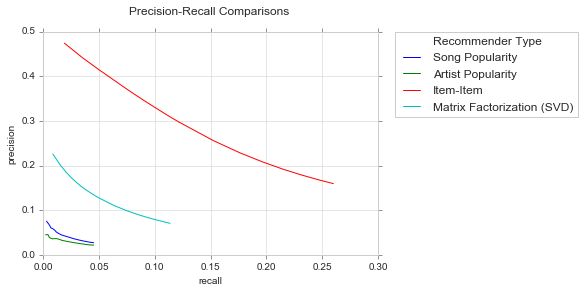

In [53]:
%matplotlib inline

sns.set_style("whitegrid")

sns.despine()

sns.lineplot(x='recall', y='precision', data = precision_recall_overall, 
             hue='Recommender Type', markers=True)

plt.title('Precision-Recall Comparisons \n')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.xticks(np.arange(0, 1.2, step=0.2))
#plt.yticks(np.arange(0, 1.2, step=0.2))

plt.show()

In [ ]:
dill.dump_session('notebook_env.db')

## IDEAS & NEXT STEPS

+ Add other accuracy metrics
+ Other options  - content based/clutering/esemble. 
+ Limitations

# End of Notebook